# Big Mart Sales

>. To build a regression methodology to determine the sales of items at a particular outlet.

## How to run this notebook??

- ensure the input data absolute path is 'Sales_Training.csv' 
- import the libraries (1.2)
- run all the functions (1.10)
- run sequentially (1.3 onwards)

## Importing the Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
import time 
from datetime import datetime
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from sklearn.metrics import davies_bouldin_score
import scipy.cluster.hierarchy as shc

from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics
from time import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Reading the Data

In [16]:
df_main=pd.read_csv('Sales_Training.csv')
df_main.head(5)

Item_Identifier  Item_Weight  Item_Visibility  Item_MRP Outlet_Identifier  \
0           FDA15         9.30         0.016047  249.8092            OUT049   
1           DRC01         5.92         0.019278   48.2692            OUT018   
2           FDN15        17.50         0.016760  141.6180            OUT049   
3           FDX07        19.20         0.017834  182.0950            OUT010   
4           NCD19         8.93         0.009780   53.8614            OUT013   

   Item_Outlet_Sales  Outlet_Years  Item_Fat_Content_0  Item_Fat_Content_1  \
0          3735.1380            10                   1                   0   
1           443.4228             0                   0                   1   
2          2097.2700            10                   1                   0   
3           732.3800            11                   0                   1   
4           994.7052            22                   1                   0   

   Outlet_Location_Type_0  ...  Outlet_0  Outlet_1  Outlet_2  Outlet_3  \
0                       1  ...         0         0         0         0   
1                       0  ...         0         0         0         1   
2                       1  ...         0         0         0         0   
3                       0  ...         1         0         0         0   
4                       0  ...         0         1         0         0   

   Outlet_4  Outlet_5  Outlet_6  Outlet_7  Outlet_8  Outlet_9  
0         0         0         0         0         0         1  
1         0         0         0         0         0         0  
2         0         0         0         0         0         1  
3         0         0         0         0         0         0  
4         0         0         0         0         0         0  

[5 rows x 33 columns]

In [17]:
df_main.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Item_Outlet_Sales', 'Outlet_Years',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Size_3', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3',
       'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2',
       'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9'],
      dtype='object')

In [18]:
x=df_main[['Outlet_Identifier','Item_Identifier']].groupby(['Item_Identifier'])['Outlet_Identifier'].agg({'nunique'})
x[x['nunique']>1]

nunique
Item_Identifier         
DRA12                  4
DRB13                  2
DRB48                  4
DRC27                  2
DRD24                  3
...                  ...
NCY41                  4
NCZ06                  4
NCZ18                  3
NCZ42                  2
NCZ54                  3

[585 rows x 1 columns]

In [19]:
df_main[['Outlet_Identifier','Item_Identifier']].groupby(['Outlet_Identifier'])['Item_Identifier'].agg({'count','nunique'})

count  nunique
Outlet_Identifier                
OUT010               295      121
OUT013               555      225
OUT017               557      215
OUT018               524      203
OUT019               317      125
OUT027               530      227
OUT035               560      221
OUT045               580      235
OUT046               548      224
OUT049               539      206

<b>insights</b>
- one outlet has multiple products & one product could be sold in multiple outlets. we will keep item id as prediction index, as for outlet identifier, it can be discarded as there are 10 different outlets & its already one hot encoded to produce the columns [Outlet_0],[Outlet_1] ,[Outlet_2]  ,[Outlet_3]   ,[Outlet_4]   ,[Outlet_5]   ,[Outlet_6]  ,[Outlet_7] ,[Outlet_8]
,[Outlet_9].

- the table below shows 'OUTLET_IDENTIFIER' based on the values of outlet_i where i is number of outlets -1

In [20]:
df_main[['Outlet_Identifier','Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9']].drop_duplicates().reset_index(drop=True)

Outlet_Identifier  Outlet_0  Outlet_1  Outlet_2  Outlet_3  Outlet_4  \
0            OUT049         0         0         0         0         0   
1            OUT018         0         0         0         1         0   
2            OUT010         1         0         0         0         0   
3            OUT013         0         1         0         0         0   
4            OUT027         0         0         0         0         0   
5            OUT045         0         0         0         0         0   
6            OUT017         0         0         1         0         0   
7            OUT046         0         0         0         0         0   
8            OUT035         0         0         0         0         0   
9            OUT019         0         0         0         0         1   

   Outlet_5  Outlet_6  Outlet_7  Outlet_8  Outlet_9  
0         0         0         0         0         1  
1         0         0         0         0         0  
2         0         0         0         0         0  
3         0         0         0         0         0  
4         1         0         0         0         0  
5         0         0         1         0         0  
6         0         0         0         0         0  
7         0         0         0         1         0  
8         0         1         0         0         0  
9         0         0         0         0         0

In [21]:
df=df_main.copy()

## Exploratory Data Analysis
there are main components of exploring data:
- Understanding your variables
- Cleaning your dataset
- Analyzing relationships between variables

### List of Columns

In [22]:
print('list of parameters in the data ')
df.columns

list of parameters in the data 


Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Item_Outlet_Sales', 'Outlet_Years',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Size_3', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3',
       'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2',
       'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9'],
      dtype='object')

In [23]:
print('number of rows in the data',df.shape[0])
print('number of columns in the data',df.shape[1])

number of rows in the data 5005
number of columns in the data 33


### Summary Statistics 

In [24]:
df.describe().T

count         mean          std       min  \
Item_Weight             5005.0    13.012739     4.570505   4.59000   
Item_Visibility         5005.0     0.071238     0.049871   0.00478   
Item_MRP                5005.0   142.253086    62.656992  31.29000   
Item_Outlet_Sales       5005.0  2233.863293  1754.290056  33.29000   
Outlet_Years            5005.0    11.133467     8.354372   0.00000   
Item_Fat_Content_0      5005.0     0.654745     0.475499   0.00000   
Item_Fat_Content_1      5005.0     0.345255     0.475499   0.00000   
Outlet_Location_Type_0  5005.0     0.280519     0.449298   0.00000   
Outlet_Location_Type_1  5005.0     0.339061     0.473438   0.00000   
Outlet_Location_Type_2  5005.0     0.380420     0.485538   0.00000   
Outlet_Size_0           5005.0     0.110889     0.314026   0.00000   
Outlet_Size_1           5005.0     0.318282     0.465856   0.00000   
Outlet_Size_2           5005.0     0.511888     0.499909   0.00000   
Outlet_Size_3           5005.0     0.058941     0.235538   0.00000   
Outlet_Type_0           5005.0     0.122278     0.327639   0.00000   
Outlet_Type_1           5005.0     0.667133     0.471287   0.00000   
Outlet_Type_2           5005.0     0.104695     0.306191   0.00000   
Outlet_Type_3           5005.0     0.105894     0.307733   0.00000   
Item_Type_Combined_0    5005.0     0.096304     0.295037   0.00000   
Item_Type_Combined_1    5005.0     0.721079     0.448513   0.00000   
Item_Type_Combined_2    5005.0     0.182617     0.386391   0.00000   
Outlet_0                5005.0     0.058941     0.235538   0.00000   
Outlet_1                5005.0     0.110889     0.314026   0.00000   
Outlet_2                5005.0     0.111289     0.314521   0.00000   
Outlet_3                5005.0     0.104695     0.306191   0.00000   
Outlet_4                5005.0     0.063337     0.243592   0.00000   
Outlet_5                5005.0     0.105894     0.307733   0.00000   
Outlet_6                5005.0     0.111888     0.315260   0.00000   
Outlet_7                5005.0     0.115884     0.320118   0.00000   
Outlet_8                5005.0     0.109491     0.312285   0.00000   
Outlet_9                5005.0     0.107692     0.310022   0.00000   

                               25%          50%          75%           max  
Item_Weight               9.000000    13.000000    16.850000     21.350000  
Item_Visibility           0.032284     0.061331     0.098664      0.328391  
Item_MRP                 93.912000   145.047000   187.387200    265.222600  
Item_Outlet_Sales       866.871600  1808.312800  3125.931000  11445.102000  
Outlet_Years              5.000000    10.000000    22.000000     24.000000  
Item_Fat_Content_0        0.000000     1.000000     1.000000      1.000000  
Item_Fat_Content_1        0.000000     0.000000     1.000000      1.000000  
Outlet_Location_Type_0    0.000000     0.000000     1.000000      1.000000  
Outlet_Location_Type_1    0.000000     0.000000     1.000000      1.000000  
Outlet_Location_Type_2    0.000000     0.000000     1.000000      1.000000  
Outlet_Size_0             0.000000     0.000000     0.000000      1.000000  
Outlet_Size_1             0.000000     0.000000     1.000000      1.000000  
Outlet_Size_2             0.000000     1.000000     1.000000      1.000000  
Outlet_Size_3             0.000000     0.000000     0.000000      1.000000  
Outlet_Type_0             0.000000     0.000000     0.000000      1.000000  
Outlet_Type_1             0.000000     1.000000     1.000000      1.000000  
Outlet_Type_2             0.000000     0.000000     0.000000      1.000000  
Outlet_Type_3             0.000000     0.000000     0.000000      1.000000  
Item_Type_Combined_0      0.000000     0.000000     0.000000      1.000000  
Item_Type_Combined_1      0.000000     1.000000     1.000000      1.000000  
Item_Type_Combined_2      0.000000     0.000000     0.000000      1.000000  
Outlet_0                  0.000000     0.000000     0.000000      1.000000  
Outlet_1     

<b> Insights </b>
- all columns have count of 200 i.e there are no null values in any column
- but there is '?' instead

In [25]:
df.replace('?', np.NAN, inplace=True)

### Null values per column

In [26]:
#double check the null values
print('Null values in the number of columns ?')
df.isnull().any().sum()

Null values in the number of columns ?


0

In [27]:
df.isnull().sum()

Item_Identifier           0
Item_Weight               0
Item_Visibility           0
Item_MRP                  0
Outlet_Identifier         0
Item_Outlet_Sales         0
Outlet_Years              0
Item_Fat_Content_0        0
Item_Fat_Content_1        0
Outlet_Location_Type_0    0
Outlet_Location_Type_1    0
Outlet_Location_Type_2    0
Outlet_Size_0             0
Outlet_Size_1             0
Outlet_Size_2             0
Outlet_Size_3             0
Outlet_Type_0             0
Outlet_Type_1             0
Outlet_Type_2             0
Outlet_Type_3             0
Item_Type_Combined_0      0
Item_Type_Combined_1      0
Item_Type_Combined_2      0
Outlet_0                  0
Outlet_1                  0
Outlet_2                  0
Outlet_3                  0
Outlet_4                  0
Outlet_5                  0
Outlet_6                  0
Outlet_7                  0
Outlet_8                  0
Outlet_9                  0
dtype: int64

In [28]:
bool_value= False
columns_with_null = []

count_null = df.isnull().sum()
for count_ in count_null:
    if count_ > 0:
        bool_value= True

if bool_value:
    null_df = pd.DataFrame(count_null).reset_index().rename(columns={'index': 'col_name', 0:'no_of_nulls'})
    columns_with_null = list(null_df[null_df['no_of_nulls'] > 0]['col_name'].values)

In [29]:
columns_with_null

[]

### Data types of columns

In [30]:
#checking for data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5005 entries, 0 to 5004
Data columns (total 33 columns):
Item_Identifier           5005 non-null object
Item_Weight               5005 non-null float64
Item_Visibility           5005 non-null float64
Item_MRP                  5005 non-null float64
Outlet_Identifier         5005 non-null object
Item_Outlet_Sales         5005 non-null float64
Outlet_Years              5005 non-null int64
Item_Fat_Content_0        5005 non-null int64
Item_Fat_Content_1        5005 non-null int64
Outlet_Location_Type_0    5005 non-null int64
Outlet_Location_Type_1    5005 non-null int64
Outlet_Location_Type_2    5005 non-null int64
Outlet_Size_0             5005 non-null int64
Outlet_Size_1             5005 non-null int64
Outlet_Size_2             5005 non-null int64
Outlet_Size_3             5005 non-null int64
Outlet_Type_0             5005 non-null int64
Outlet_Type_1             5005 non-null int64
Outlet_Type_2             5005 non-null int64
Outlet_Ty

### Encoding Categorical Columns

from doccumentation we know , we have the following as categorical features, but its already one hot encoded data.

#### Data Distribution

In [31]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Item_Outlet_Sales', 'Outlet_Years',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Size_3', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3',
       'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2',
       'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9'],
      dtype='object')

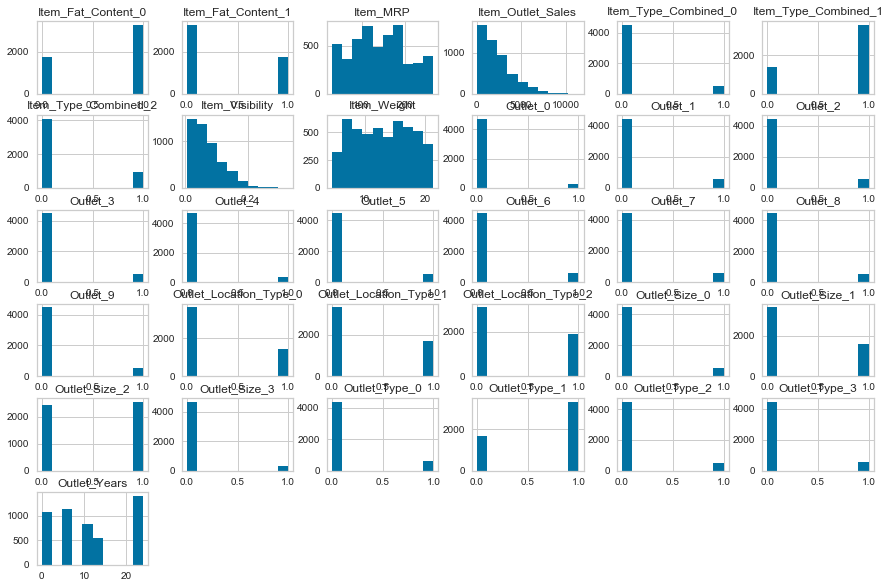

In [32]:
p=df.hist(figsize=(15,10))

###  Outlier detection

#### Box Plot 

In [33]:
df_main.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Item_Outlet_Sales', 'Outlet_Years',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Size_3', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3',
       'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2',
       'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9'],
      dtype='object')

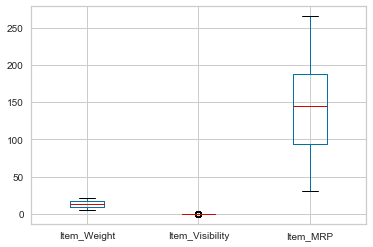

In [34]:
df[['Item_Weight', 'Item_Visibility', 'Item_MRP']].boxplot()

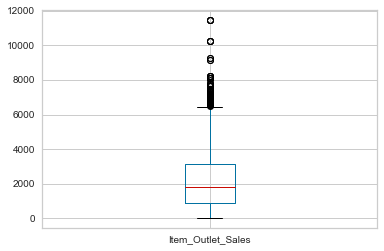

In [35]:
df[['Item_Outlet_Sales']].boxplot()

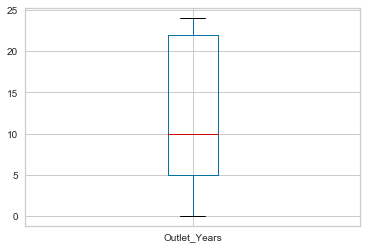

In [36]:
df[['Outlet_Years']].boxplot()

### Relationship between Parameters 

#### Item_MRP

C:\Users\affine\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



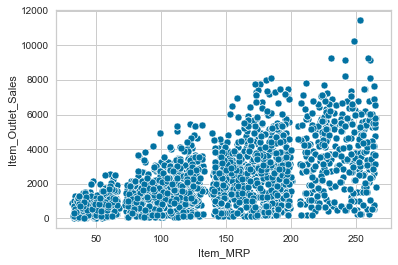

In [37]:
p=sns.scatterplot(df_main["Item_MRP"],df_main["Item_Outlet_Sales"])

#### Item_Visibility


In [38]:
df_main['Item_Visibility'].unique()

array([0.0160473 , 0.01927822, 0.01676007, ..., 0.03922186, 0.02158192,
       0.128206  ])

C:\Users\affine\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



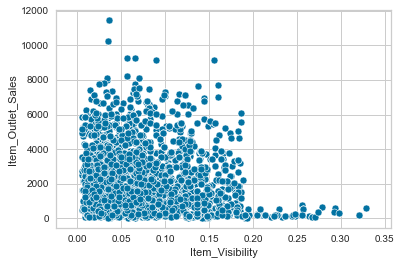

In [39]:
p=sns.scatterplot(df_main["Item_Visibility"],df_main["Item_Outlet_Sales"])

#### Outlet Years

C:\Users\affine\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



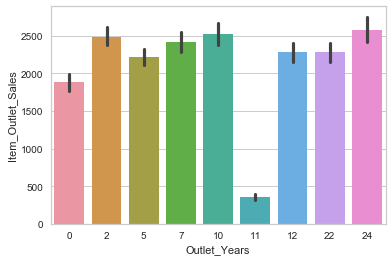

In [40]:
p=sns.barplot(df_main["Outlet_Years"],df_main["Item_Outlet_Sales"])

#### Outlet name

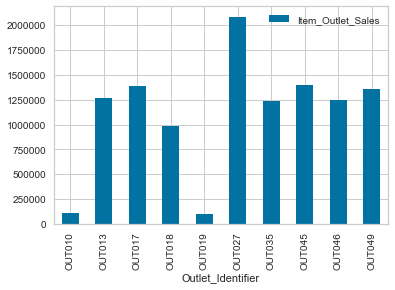

In [41]:
temp=df_main[["Outlet_Identifier",'Item_Outlet_Sales']].groupby(["Outlet_Identifier"]).agg({'Item_Outlet_Sales':'sum'})
temp.plot(kind="bar")

In [42]:
plt.figure(figsize = (14,9))
sns.boxplot(x='Outlet_Identifier', y='Item_Outlet_Sales', data=df_main, palette="Set1")
plt.title("Outlet_Identifier vs Item_Outlet_Sales ")

Text(0.5, 1.0, 'Outlet_Identifier vs Item_Outlet_Sales ')

#### Item Type


In [43]:
x,y,z = df_main[df_main["Item_Type_Combined_0"]==1],df_main[df_main["Item_Type_Combined_1"]==1],df_main[df_main["Item_Type_Combined_2"]==1]

In [44]:
df_pie = pd.DataFrame([[x.shape[0],y.shape[0],z.shape[0]]], columns=["Item_Type_Combined_0","Item_Type_Combined_1","Item_Type_Combined_2"])

In [45]:
df_pie

Item_Type_Combined_0  Item_Type_Combined_1  Item_Type_Combined_2
0                   482                  3609                   914

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



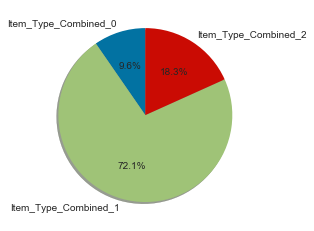

In [46]:
plt.pie(df_pie, labels=df_pie.columns, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

In [47]:
column= ["Item_Type_Combined_0","Item_Type_Combined_1","Item_Type_Combined_2"]
for col in column:
    print(col,df_main[df_main[col]==1][col].value_counts()[1])

Item_Type_Combined_0 482
Item_Type_Combined_1 3609
Item_Type_Combined_2 914


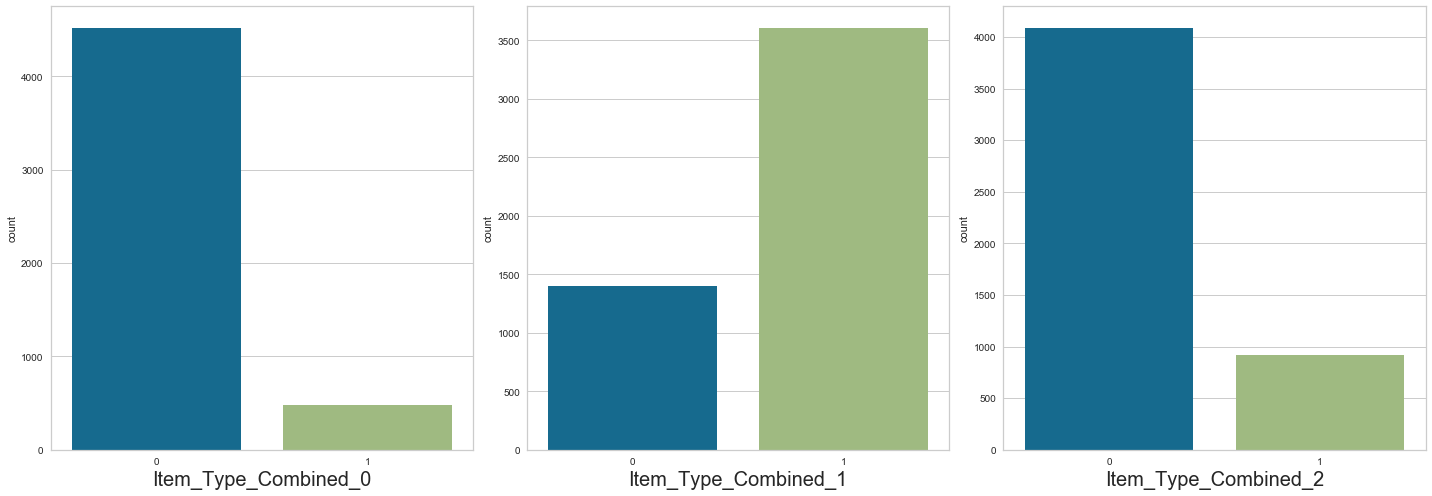

In [48]:
plt.figure(figsize=(20,7), facecolor='white')
plotnumber = 1
for column in ["Item_Type_Combined_0","Item_Type_Combined_1","Item_Type_Combined_2"]:
    ax = plt.subplot(1,3,plotnumber)
    sns.countplot(x = column,data = df_main,ax=ax)
    plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.tight_layout()

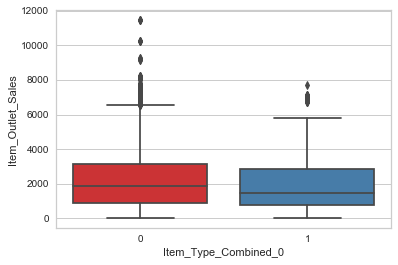

In [49]:
sns.boxplot(x='Item_Type_Combined_0', y='Item_Outlet_Sales', data=df_main, palette="Set1")

#### Item Fat Content

In [50]:
x,y = df_main[df_main["Item_Fat_Content_0"]==1],df_main[df_main["Item_Fat_Content_1"]==1]
df_pie = pd.DataFrame([[x.shape[0],y.shape[0]]], columns=["Item_Fat_Content_0","Item_Fat_Content_1"])

In [51]:
df_pie

Item_Fat_Content_0  Item_Fat_Content_1
0                3277                1728

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



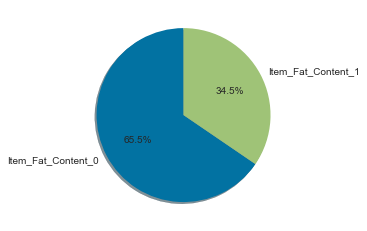

In [52]:
plt.pie(df_pie, labels=df_pie.columns, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

#### Outlet Location

In [53]:
x=df_main[df_main["Outlet_Location_Type_0"]==1]['Item_Outlet_Sales'].sum()
y=df_main[df_main["Outlet_Location_Type_1"]==1]['Item_Outlet_Sales'].sum()
z=df_main[df_main["Outlet_Location_Type_2"]==1]['Item_Outlet_Sales'].sum()
temp=pd.DataFrame([x,y,z],index=["Outlet_Location_Type_0","Outlet_Location_Type_1","Outlet_Location_Type_2"],columns=['sales'])
temp.head()

sales
Outlet_Location_Type_0  2.712625e+06
Outlet_Location_Type_1  4.027673e+06
Outlet_Location_Type_2  4.440188e+06

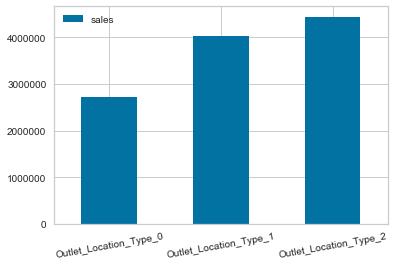

In [54]:
temp.plot(kind='bar',rot=10)

#### Sales by Product

In [55]:
df_main['Item_Identifier'].unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'FDZ43', 'FDJ50', 'FDV35'],
      dtype=object)

In [56]:
temp=df_main[["Item_Identifier",'Item_Outlet_Sales']].groupby(["Item_Identifier"]).agg({'Item_Outlet_Sales':'sum'})
temp['Item_Outlet_Sales']=round(temp['Item_Outlet_Sales'],2)
temp=temp.sort_values(by = 'Item_Outlet_Sales',ascending=False)

##### Top 20 selling products

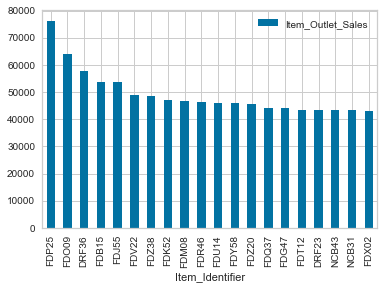

In [57]:
temp.head(20).plot(kind='bar')

##### Bottom  20 selling products

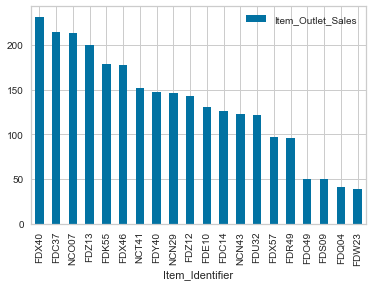

In [58]:
temp.tail(20).plot(kind='bar')

### Correlation matrix and its heat map
- <b>A correlation matrix </b>is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses.

In [59]:
df_main.corr()

Item_Weight  Item_Visibility  Item_MRP  \
Item_Weight                1.000000        -0.028674 -0.000255   
Item_Visibility           -0.028674         1.000000 -0.030495   
Item_MRP                  -0.000255        -0.030495  1.000000   
Item_Outlet_Sales          0.010784        -0.141637  0.586390   
Outlet_Years               0.016975         0.100036  0.003133   
Item_Fat_Content_0         0.024335        -0.032534 -0.026634   
Item_Fat_Content_1        -0.024335         0.032534  0.026634   
Outlet_Location_Type_0    -0.022108         0.070483 -0.016943   
Outlet_Location_Type_1     0.012272        -0.091197  0.025257   
Outlet_Location_Type_2     0.008492         0.023702 -0.008949   
Outlet_Size_0              0.010177        -0.022856  0.005037   
Outlet_Size_1             -0.033718        -0.081995 -0.017949   
Outlet_Size_2              0.014391         0.006719  0.021439   
Outlet_Size_3              0.022577         0.178385 -0.016716   
Outlet_Type_0              0.014369         0.293736 -0.026162   
Outlet_Type_1             -0.000673        -0.154702  0.022409   
Outlet_Type_2             -0.028762        -0.031459 -0.019139   
Outlet_Type_3              0.014350        -0.044514  0.012579   
Item_Type_Combined_0      -0.060947        -0.025330 -0.062313   
Item_Type_Combined_1       0.010059         0.048820  0.066332   
Item_Type_Combined_2       0.034861        -0.037328 -0.029417   
Outlet_0                   0.022577         0.178385 -0.016716   
Outlet_1                   0.010177        -0.022856  0.005037   
Outlet_2                   0.012942        -0.042400  0.006770   
Outlet_3                  -0.028762        -0.031459 -0.019139   
Outlet_4                  -0.002504         0.222598 -0.019026   
Outlet_5                   0.014350        -0.044514  0.012579   
Outlet_6                   0.014923        -0.056060 -0.004686   
Outlet_7                  -0.009263        -0.038007  0.035316   
Outlet_8                   0.006385        -0.024618  0.010870   
Outlet_9                  -0.036504        -0.047956 -0.020555   

                        Item_Outlet_Sales  Outlet_Years  Item_Fat_Content_0  \
Item_Weight                      0.010784      0.016975            0.024335   
Item_Visibility                 -0.141637      0.100036           -0.032534   
Item_MRP                         0.586390      0.003133           -0.026634   
Item_Outlet_Sales                1.000000      0.059710           -0.032061   
Outlet_Years                     0.059710      1.000000            0.020204   
Item_Fat_Content_0              -0.032061      0.020204            1.000000   
Item_Fat_Content_1               0.032061     -0.020204           -1.000000   
Outlet_Location_Type_0          -0.107430      0.209903            0.042783   
Outlet_Location_Type_1           0.056979     -0.551707           -0.038263   
Outlet_Location_Type_2           0.043853      0.343721           -0.002281   
Outlet_Size_0                    0.009033      0.459396           -0.036649   
Outlet_Size_1                    0.213349      0.019224            0.033371   
Outlet_Size_2                   -0.078258     -0.304608           -0.008792   
Outlet_Size_3                   -0.267919     -0.003999            0.001517   
Outlet_Type_0                   -0.402819      0.294904            0.031165   
Outlet_Type_1                    0.106981     -0.255029           -0.042978   
Outlet_Type_2                   -0.068616     -0.455762            0.010862   
Outlet_Type_3                    0.333309      0.530069            0.021831   
Item_Type_Combined_0            -0.042982     -0.003756            0.170101   
Item_Type_Combined_1             0.061257      0.027430           -0.407589   
Item_Type_Combined_2            -0.038286     -0.028972            0.343235   
Outlet_0                        -0.267919     -0.003999            0.001517   
Outlet_1                         0.009033      0.459396           -0.036649   
Outlet_2       

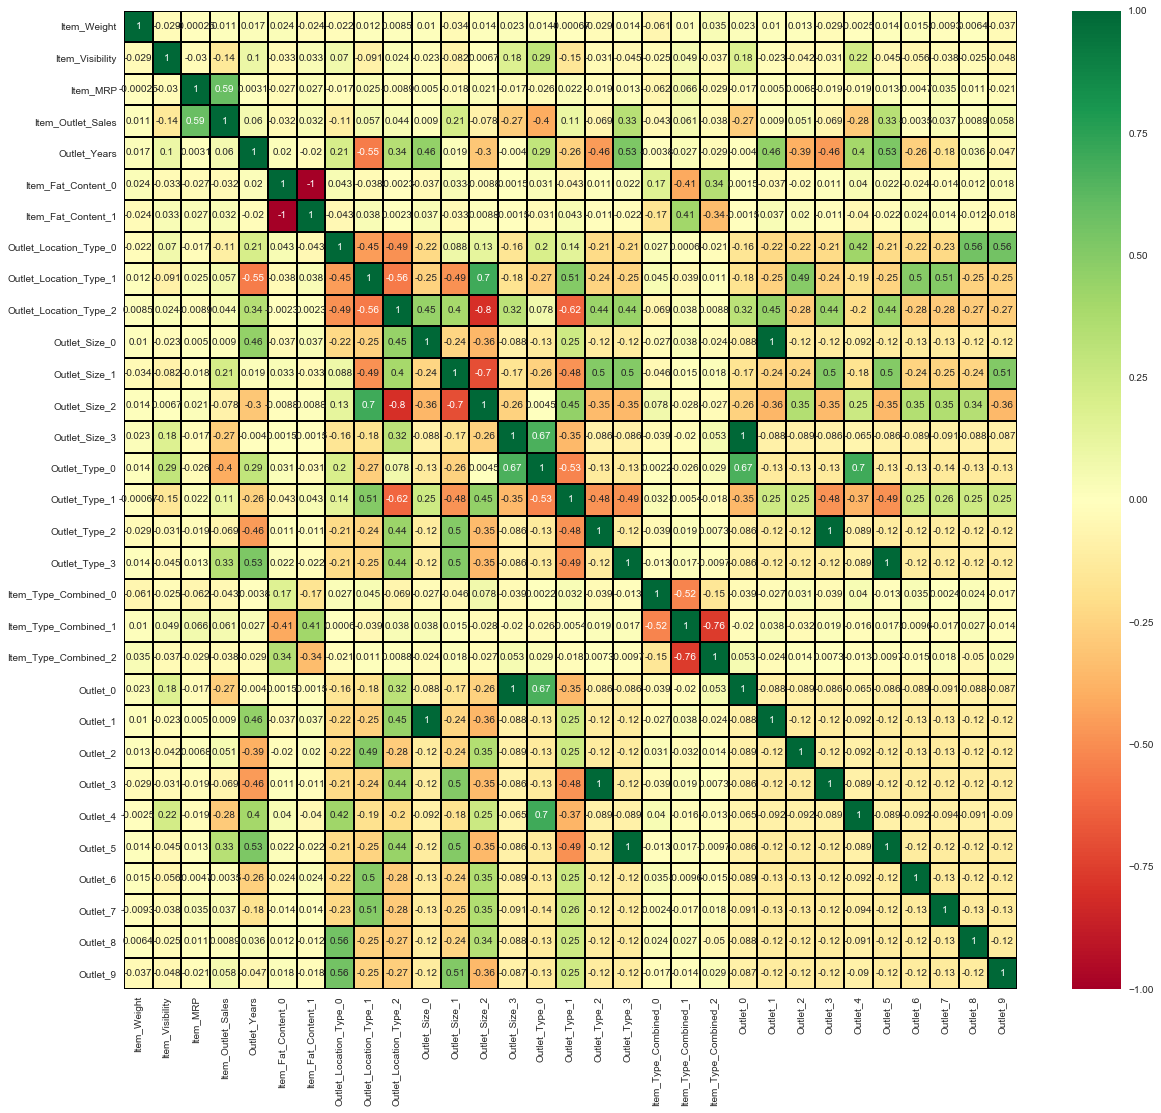

In [60]:
plt.figure(figsize=(20,18))
#matrix = np.triu(df_main.corr())
p=sns.heatmap(df_main.corr(), annot=True,cmap= 'RdYlGn',linewidths=1, linecolor='black')

## Data Prep 

#### Final Data for modeling

In [61]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Item_Outlet_Sales', 'Outlet_Years',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Size_3', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3',
       'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2',
       'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9'],
      dtype='object')

In [62]:
df.drop(columns=["Item_Identifier","Outlet_Identifier"],inplace=True)

In [63]:
X = df_main.drop(["Item_Identifier","Outlet_Identifier","Item_Outlet_Sales"],axis=1)
y = df_main["Item_Outlet_Sales"]

In [64]:
X.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Years  Item_Fat_Content_0  \
0         9.30         0.016047  249.8092            10                   1   
1         5.92         0.019278   48.2692             0                   0   
2        17.50         0.016760  141.6180            10                   1   
3        19.20         0.017834  182.0950            11                   0   
4         8.93         0.009780   53.8614            22                   1   

   Item_Fat_Content_1  Outlet_Location_Type_0  Outlet_Location_Type_1  \
0                   0                       1                       0   
1                   1                       0                       0   
2                   0                       1                       0   
3                   1                       0                       0   
4                   0                       0                       0   

   Outlet_Location_Type_2  Outlet_Size_0  ...  Outlet_0  Outlet_1  Outlet_2  \
0                       0              0  ...         0         0         0   
1                       1              0  ...         0         0         0   
2                       0              0  ...         0         0         0   
3                       1              0  ...         1         0         0   
4                       1              1  ...         0         1         0   

   Outlet_3  Outlet_4  Outlet_5  Outlet_6  Outlet_7  Outlet_8  Outlet_9  
0         0         0         0         0         0         0         1  
1         1         0         0         0         0         0         0  
2         0         0         0         0         0         0         1  
3         0         0         0         0         0         0         0  
4         0         0         0         0         0         0         0  

[5 rows x 30 columns]

In [65]:
y.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

## Model

In [66]:
import sklearn
x_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(X,y,test_size=1 / 3,random_state=0)                                                                                                                                                                                     

### Linear Regression

In [67]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
reg.score(x_train,y_train)

0.5829014005926508

In [69]:
reg.score(x_test,y_test)

0.5745067008281586

### Ridge Regression

In [71]:
from sklearn.preprocessing import PolynomialFeatures
poly= PolynomialFeatures(2)
x_tr=poly.fit_transform(x_train)
x_te=poly.transform(x_test)

In [72]:
(x_train.shape,x_tr.shape)

((3336, 30), (3336, 496))

In [73]:
from sklearn.linear_model import RidgeCV
reg=RidgeCV(cv=5,scoring='neg_mean_absolute_error')
reg.fit(x_tr,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring='neg_mean_absolute_error',
        store_cv_values=False)

In [74]:
reg.score(x_tr,y_train)

0.6339190443896361

In [75]:
reg.score(x_te,y_test)

0.6268405557416854

### Random forest

In [76]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor()

estimator.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [77]:
estimator.score(x_train,y_train)

0.9805070802427924

In [78]:
estimator.score(x_test,y_test)

0.8480563202395021

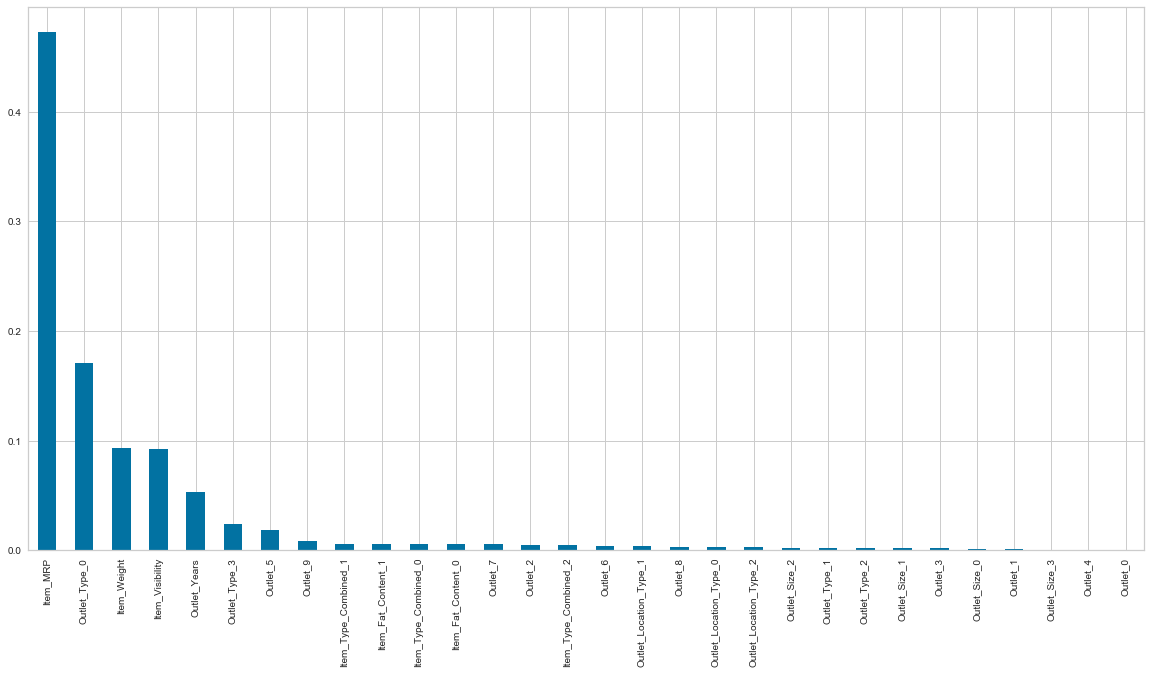

In [79]:
p=pd.Series(estimator.feature_importances_,X.columns).sort_values(ascending=False).plot(kind='bar',figsize=(20,10))

### Hyperparameter tuning using Grid Search

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor

model_params = {
    'Linear_reg': {
        'model': LinearRegression(),
        'params' : {
                'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]

            }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {"n_estimators": [10, 50, 100, 130],
                     'criterion':['mse'],
                        "max_depth": [None,2,3,4],
                       "max_features": ['auto', 'log2']
                       }
    },
    'ExtraTree_reg' : {
        'model': ExtraTreesRegressor(),
        'params': {"n_estimators": [10, 50, 100, 130],
                     'criterion':['mse'],
                        "max_depth": [None,2,3,4],
                       "max_features": ['auto', 'log2']
                    }
    },
     'CatBoost_reg':
        {
         'model':CatBoostRegressor(),
         'params':{"n_estimators": [130,200],
                     'loss_function':['RMSE','MAE'],
                   'learning_rate':[0.01,0.5,1]
                  
                      
                    }
        }
    
    }


In [81]:
scores = []

for model_name, mp in model_params.items():
    reg =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    reg.fit(x_train, y_train)
    scores.append({
        'model name' :model_name,
        'model': reg.best_estimator_,
        'best_score': reg.best_score_,
        'best_params': reg.best_params_,
        'R2_score' : sklearn.metrics.r2_score( y_test,reg.best_estimator_.predict(x_test))
    })
    
df1 = pd.DataFrame(scores,columns=['model name','model','best_score','best_params','R2_score'])


0:	learn: 1722.6568390	total: 183ms	remaining: 23.6s
1:	learn: 1713.2948690	total: 193ms	remaining: 12.4s
2:	learn: 1704.2264131	total: 203ms	remaining: 8.58s
3:	learn: 1694.9734443	total: 212ms	remaining: 6.69s
4:	learn: 1686.4903392	total: 216ms	remaining: 5.41s
5:	learn: 1677.1368405	total: 220ms	remaining: 4.55s
6:	learn: 1668.0450769	total: 225ms	remaining: 3.95s
7:	learn: 1659.3933747	total: 229ms	remaining: 3.48s
8:	learn: 1650.4958581	total: 232ms	remaining: 3.12s
9:	learn: 1642.2307188	total: 235ms	remaining: 2.82s
10:	learn: 1633.9016115	total: 240ms	remaining: 2.59s
11:	learn: 1626.0123336	total: 243ms	remaining: 2.39s
12:	learn: 1617.4378132	total: 247ms	remaining: 2.23s
13:	learn: 1608.9231538	total: 251ms	remaining: 2.08s
14:	learn: 1600.7772872	total: 255ms	remaining: 1.95s
15:	learn: 1592.8590533	total: 258ms	remaining: 1.84s
16:	learn: 1585.2890346	total: 261ms	remaining: 1.74s
17:	learn: 1577.1953829	total: 264ms	remaining: 1.64s
18:	learn: 1570.0752771	total: 267ms	r

44:	learn: 1425.4376562	total: 176ms	remaining: 333ms
45:	learn: 1420.0871966	total: 183ms	remaining: 334ms
46:	learn: 1415.0107711	total: 187ms	remaining: 330ms
47:	learn: 1410.6230005	total: 191ms	remaining: 327ms
48:	learn: 1405.3370068	total: 196ms	remaining: 324ms
49:	learn: 1400.4159761	total: 200ms	remaining: 320ms
50:	learn: 1395.7494386	total: 204ms	remaining: 316ms
51:	learn: 1390.8618424	total: 209ms	remaining: 314ms
52:	learn: 1386.0896034	total: 214ms	remaining: 310ms
53:	learn: 1381.1050725	total: 217ms	remaining: 305ms
54:	learn: 1376.3322817	total: 220ms	remaining: 299ms
55:	learn: 1371.6581096	total: 223ms	remaining: 294ms
56:	learn: 1367.2580051	total: 226ms	remaining: 290ms
57:	learn: 1362.7542408	total: 230ms	remaining: 285ms
58:	learn: 1358.0911961	total: 233ms	remaining: 280ms
59:	learn: 1353.8249952	total: 236ms	remaining: 275ms
60:	learn: 1349.3298853	total: 239ms	remaining: 270ms
61:	learn: 1345.0001292	total: 242ms	remaining: 266ms
62:	learn: 1340.5843793	tota

93:	learn: 1214.3367362	total: 353ms	remaining: 135ms
94:	learn: 1211.9446082	total: 357ms	remaining: 132ms
95:	learn: 1209.6632057	total: 364ms	remaining: 129ms
96:	learn: 1207.1574760	total: 368ms	remaining: 125ms
97:	learn: 1204.5345274	total: 373ms	remaining: 122ms
98:	learn: 1201.8405086	total: 377ms	remaining: 118ms
99:	learn: 1199.9747396	total: 380ms	remaining: 114ms
100:	learn: 1197.7695771	total: 383ms	remaining: 110ms
101:	learn: 1195.4990036	total: 387ms	remaining: 106ms
102:	learn: 1193.1358550	total: 392ms	remaining: 103ms
103:	learn: 1190.8943440	total: 395ms	remaining: 98.8ms
104:	learn: 1188.5246236	total: 398ms	remaining: 94.9ms
105:	learn: 1186.1983225	total: 402ms	remaining: 90.9ms
106:	learn: 1184.1529770	total: 405ms	remaining: 87.1ms
107:	learn: 1181.9151316	total: 408ms	remaining: 83.2ms
108:	learn: 1179.9039893	total: 412ms	remaining: 79.3ms
109:	learn: 1177.9485701	total: 415ms	remaining: 75.4ms
110:	learn: 1176.3466898	total: 418ms	remaining: 71.5ms
111:	lear

0:	learn: 1707.4164731	total: 2.97ms	remaining: 383ms
1:	learn: 1698.2447012	total: 6.58ms	remaining: 421ms
2:	learn: 1689.1710646	total: 9.91ms	remaining: 420ms
3:	learn: 1679.9802963	total: 13.5ms	remaining: 424ms
4:	learn: 1671.9699370	total: 16.7ms	remaining: 418ms
5:	learn: 1662.7903544	total: 21.9ms	remaining: 454ms
6:	learn: 1654.1645842	total: 25.2ms	remaining: 444ms
7:	learn: 1646.2104140	total: 29.1ms	remaining: 444ms
8:	learn: 1637.4428011	total: 32.5ms	remaining: 436ms
9:	learn: 1629.2911643	total: 36.1ms	remaining: 433ms
10:	learn: 1621.1742089	total: 39.5ms	remaining: 428ms
11:	learn: 1613.1875326	total: 42.9ms	remaining: 422ms
12:	learn: 1605.3843154	total: 46.6ms	remaining: 420ms
13:	learn: 1597.2297574	total: 50ms	remaining: 414ms
14:	learn: 1590.3810611	total: 52.2ms	remaining: 400ms
15:	learn: 1582.7735509	total: 55.3ms	remaining: 394ms
16:	learn: 1575.4238219	total: 58.8ms	remaining: 391ms
17:	learn: 1567.9373958	total: 62.4ms	remaining: 388ms
18:	learn: 1560.878142

52:	learn: 1367.0589515	total: 175ms	remaining: 487ms
53:	learn: 1362.1508010	total: 181ms	remaining: 489ms
54:	learn: 1357.8106618	total: 185ms	remaining: 488ms
55:	learn: 1353.2600026	total: 194ms	remaining: 498ms
56:	learn: 1348.6279239	total: 198ms	remaining: 496ms
57:	learn: 1344.1487712	total: 202ms	remaining: 494ms
58:	learn: 1339.7994149	total: 207ms	remaining: 494ms
59:	learn: 1335.5334607	total: 210ms	remaining: 491ms
60:	learn: 1331.4215056	total: 213ms	remaining: 486ms
61:	learn: 1327.1455263	total: 216ms	remaining: 482ms
62:	learn: 1322.9335828	total: 220ms	remaining: 478ms
63:	learn: 1318.7150424	total: 223ms	remaining: 474ms
64:	learn: 1315.0039158	total: 226ms	remaining: 470ms
65:	learn: 1311.0325280	total: 229ms	remaining: 466ms
66:	learn: 1307.6949483	total: 232ms	remaining: 461ms
67:	learn: 1303.5559160	total: 235ms	remaining: 457ms
68:	learn: 1299.8762402	total: 239ms	remaining: 454ms
69:	learn: 1296.3369131	total: 242ms	remaining: 449ms
70:	learn: 1292.6146023	tota

48:	learn: 1405.3370068	total: 185ms	remaining: 570ms
49:	learn: 1400.4159761	total: 190ms	remaining: 569ms
50:	learn: 1395.7494386	total: 194ms	remaining: 566ms
51:	learn: 1390.8618424	total: 198ms	remaining: 563ms
52:	learn: 1386.0896034	total: 202ms	remaining: 560ms
53:	learn: 1381.1050725	total: 208ms	remaining: 561ms
54:	learn: 1376.3322817	total: 211ms	remaining: 557ms
55:	learn: 1371.6581096	total: 218ms	remaining: 561ms
56:	learn: 1367.2580051	total: 222ms	remaining: 558ms
57:	learn: 1362.7542408	total: 225ms	remaining: 552ms
58:	learn: 1358.0911961	total: 229ms	remaining: 546ms
59:	learn: 1353.8249952	total: 232ms	remaining: 540ms
60:	learn: 1349.3298853	total: 235ms	remaining: 536ms
61:	learn: 1345.0001292	total: 238ms	remaining: 530ms
62:	learn: 1340.5843793	total: 241ms	remaining: 525ms
63:	learn: 1336.5221748	total: 244ms	remaining: 519ms
64:	learn: 1332.0428710	total: 247ms	remaining: 513ms
65:	learn: 1328.0734675	total: 251ms	remaining: 509ms
66:	learn: 1324.0802070	tota

0:	learn: 1718.4161636	total: 2.99ms	remaining: 596ms
1:	learn: 1709.0603933	total: 6.53ms	remaining: 647ms
2:	learn: 1699.7568359	total: 10.6ms	remaining: 698ms
3:	learn: 1690.5233350	total: 14ms	remaining: 686ms
4:	learn: 1681.9257711	total: 17.5ms	remaining: 684ms
5:	learn: 1672.5465295	total: 20.9ms	remaining: 676ms
6:	learn: 1663.7402364	total: 24.5ms	remaining: 674ms
7:	learn: 1655.6734339	total: 27.7ms	remaining: 664ms
8:	learn: 1646.7890686	total: 31.4ms	remaining: 666ms
9:	learn: 1638.2533624	total: 34.7ms	remaining: 660ms
10:	learn: 1629.9394153	total: 38.1ms	remaining: 655ms
11:	learn: 1621.5323434	total: 42.1ms	remaining: 659ms
12:	learn: 1613.5638656	total: 45.5ms	remaining: 655ms
13:	learn: 1605.2258906	total: 48.9ms	remaining: 649ms
14:	learn: 1598.3222733	total: 51ms	remaining: 629ms
15:	learn: 1590.6134048	total: 54.3ms	remaining: 625ms
16:	learn: 1582.5411023	total: 58ms	remaining: 624ms
17:	learn: 1574.6201223	total: 62.8ms	remaining: 635ms
18:	learn: 1567.4518676	to

195:	learn: 1070.9078742	total: 667ms	remaining: 13.6ms
196:	learn: 1070.0084376	total: 671ms	remaining: 10.2ms
197:	learn: 1069.2717430	total: 675ms	remaining: 6.82ms
198:	learn: 1068.4904424	total: 680ms	remaining: 3.42ms
199:	learn: 1067.8280073	total: 684ms	remaining: 0us
0:	learn: 1718.2214193	total: 3.13ms	remaining: 623ms
1:	learn: 1708.7318315	total: 6.68ms	remaining: 661ms
2:	learn: 1699.5915151	total: 10.3ms	remaining: 677ms
3:	learn: 1690.1200865	total: 13.5ms	remaining: 661ms
4:	learn: 1681.2834697	total: 16.9ms	remaining: 658ms
5:	learn: 1671.9022182	total: 20.2ms	remaining: 654ms
6:	learn: 1663.1588060	total: 23.5ms	remaining: 648ms
7:	learn: 1655.1773041	total: 27.3ms	remaining: 655ms
8:	learn: 1646.2405418	total: 30.4ms	remaining: 645ms
9:	learn: 1637.9815886	total: 33.1ms	remaining: 628ms
10:	learn: 1629.7688546	total: 36.3ms	remaining: 624ms
11:	learn: 1621.9257970	total: 39.7ms	remaining: 622ms
12:	learn: 1613.7078712	total: 43.6ms	remaining: 627ms
13:	learn: 1605.18

148:	learn: 1114.0543924	total: 499ms	remaining: 171ms
149:	learn: 1112.7795434	total: 503ms	remaining: 168ms
150:	learn: 1111.5205357	total: 507ms	remaining: 165ms
151:	learn: 1110.4087139	total: 512ms	remaining: 162ms
152:	learn: 1109.1795498	total: 520ms	remaining: 160ms
153:	learn: 1108.0283370	total: 524ms	remaining: 156ms
154:	learn: 1106.8770376	total: 529ms	remaining: 154ms
155:	learn: 1105.7453071	total: 532ms	remaining: 150ms
156:	learn: 1104.6543636	total: 535ms	remaining: 147ms
157:	learn: 1103.9642299	total: 537ms	remaining: 143ms
158:	learn: 1102.7489512	total: 540ms	remaining: 139ms
159:	learn: 1101.8308217	total: 545ms	remaining: 136ms
160:	learn: 1100.7992913	total: 548ms	remaining: 133ms
161:	learn: 1099.6561041	total: 551ms	remaining: 129ms
162:	learn: 1098.5854767	total: 554ms	remaining: 126ms
163:	learn: 1097.7616332	total: 558ms	remaining: 122ms
164:	learn: 1096.7808269	total: 561ms	remaining: 119ms
165:	learn: 1095.9238006	total: 564ms	remaining: 116ms
166:	learn

144:	learn: 1122.1499242	total: 502ms	remaining: 190ms
145:	learn: 1121.2978476	total: 505ms	remaining: 187ms
146:	learn: 1119.9415706	total: 509ms	remaining: 184ms
147:	learn: 1118.6992828	total: 517ms	remaining: 182ms
148:	learn: 1117.4911365	total: 522ms	remaining: 179ms
149:	learn: 1116.5274166	total: 526ms	remaining: 175ms
150:	learn: 1115.4935378	total: 530ms	remaining: 172ms
151:	learn: 1114.3955927	total: 535ms	remaining: 169ms
152:	learn: 1113.3713510	total: 539ms	remaining: 166ms
153:	learn: 1112.1728955	total: 542ms	remaining: 162ms
154:	learn: 1110.9731574	total: 545ms	remaining: 158ms
155:	learn: 1109.8710286	total: 550ms	remaining: 155ms
156:	learn: 1108.6839151	total: 553ms	remaining: 151ms
157:	learn: 1108.0218930	total: 556ms	remaining: 148ms
158:	learn: 1107.2708405	total: 558ms	remaining: 144ms
159:	learn: 1106.3408626	total: 561ms	remaining: 140ms
160:	learn: 1105.2544631	total: 564ms	remaining: 137ms
161:	learn: 1104.1359934	total: 568ms	remaining: 133ms
162:	learn

0:	learn: 1359.5767778	total: 3.58ms	remaining: 462ms
1:	learn: 1352.0670280	total: 7.02ms	remaining: 449ms
2:	learn: 1344.7065533	total: 10.5ms	remaining: 445ms
3:	learn: 1337.0749190	total: 13.9ms	remaining: 437ms
4:	learn: 1329.2431405	total: 17.3ms	remaining: 433ms
5:	learn: 1323.5580971	total: 19.2ms	remaining: 396ms
6:	learn: 1316.4899949	total: 22.7ms	remaining: 400ms
7:	learn: 1308.9883766	total: 26.4ms	remaining: 403ms
8:	learn: 1301.2968972	total: 30.1ms	remaining: 405ms
9:	learn: 1294.0252804	total: 34.4ms	remaining: 412ms
10:	learn: 1287.0786796	total: 38.1ms	remaining: 412ms
11:	learn: 1280.1686791	total: 41.8ms	remaining: 411ms
12:	learn: 1273.1484932	total: 45.7ms	remaining: 411ms
13:	learn: 1266.7741359	total: 49.8ms	remaining: 413ms
14:	learn: 1260.3543693	total: 53.5ms	remaining: 410ms
15:	learn: 1253.9102402	total: 57.2ms	remaining: 408ms
16:	learn: 1247.9835755	total: 60.9ms	remaining: 405ms
17:	learn: 1241.2181834	total: 64.9ms	remaining: 404ms
18:	learn: 1234.4177

46:	learn: 1063.0230708	total: 186ms	remaining: 329ms
47:	learn: 1058.8337247	total: 191ms	remaining: 327ms
48:	learn: 1055.0356379	total: 196ms	remaining: 324ms
49:	learn: 1050.5541848	total: 203ms	remaining: 324ms
50:	learn: 1046.7426641	total: 208ms	remaining: 322ms
51:	learn: 1042.3757935	total: 214ms	remaining: 321ms
52:	learn: 1038.2764681	total: 219ms	remaining: 318ms
53:	learn: 1034.6623954	total: 223ms	remaining: 314ms
54:	learn: 1030.1608227	total: 227ms	remaining: 309ms
55:	learn: 1026.3719644	total: 230ms	remaining: 304ms
56:	learn: 1022.3427463	total: 233ms	remaining: 299ms
57:	learn: 1018.0940012	total: 237ms	remaining: 295ms
58:	learn: 1013.9923491	total: 241ms	remaining: 290ms
59:	learn: 1010.3360653	total: 244ms	remaining: 285ms
60:	learn: 1006.9322598	total: 248ms	remaining: 280ms
61:	learn: 1003.6149996	total: 252ms	remaining: 276ms
62:	learn: 1000.5642426	total: 255ms	remaining: 271ms
63:	learn: 996.9870652	total: 259ms	remaining: 267ms
64:	learn: 993.8663513	total:

91:	learn: 919.5172439	total: 344ms	remaining: 142ms
92:	learn: 917.1523677	total: 349ms	remaining: 139ms
93:	learn: 915.2760115	total: 353ms	remaining: 135ms
94:	learn: 913.5588139	total: 355ms	remaining: 131ms
95:	learn: 910.7028739	total: 360ms	remaining: 127ms
96:	learn: 908.3406908	total: 364ms	remaining: 124ms
97:	learn: 905.9586948	total: 370ms	remaining: 121ms
98:	learn: 904.2756730	total: 374ms	remaining: 117ms
99:	learn: 902.2267348	total: 379ms	remaining: 114ms
100:	learn: 899.8470139	total: 382ms	remaining: 110ms
101:	learn: 897.7401274	total: 386ms	remaining: 106ms
102:	learn: 895.8184476	total: 389ms	remaining: 102ms
103:	learn: 894.1202824	total: 394ms	remaining: 98.4ms
104:	learn: 892.3318088	total: 397ms	remaining: 94.5ms
105:	learn: 890.0058306	total: 400ms	remaining: 90.7ms
106:	learn: 888.6304271	total: 404ms	remaining: 86.8ms
107:	learn: 887.3087633	total: 408ms	remaining: 83.1ms
108:	learn: 884.9357063	total: 411ms	remaining: 79.2ms
109:	learn: 882.8583925	total: 

0:	learn: 1339.2217826	total: 5.59ms	remaining: 1.11s
1:	learn: 1331.8199935	total: 11.4ms	remaining: 1.13s
2:	learn: 1324.5674054	total: 17.3ms	remaining: 1.14s
3:	learn: 1317.0565956	total: 22.8ms	remaining: 1.12s
4:	learn: 1309.3256077	total: 28.4ms	remaining: 1.11s
5:	learn: 1303.4354270	total: 31.4ms	remaining: 1.01s
6:	learn: 1296.4711299	total: 36.8ms	remaining: 1.01s
7:	learn: 1289.5656209	total: 40.6ms	remaining: 975ms
8:	learn: 1281.9412276	total: 44.4ms	remaining: 942ms
9:	learn: 1275.0003561	total: 48.6ms	remaining: 923ms
10:	learn: 1268.5659620	total: 52.3ms	remaining: 899ms
11:	learn: 1261.2630024	total: 56.1ms	remaining: 880ms
12:	learn: 1254.3558583	total: 59.9ms	remaining: 862ms
13:	learn: 1247.9953213	total: 64ms	remaining: 850ms
14:	learn: 1241.4767974	total: 67.8ms	remaining: 836ms
15:	learn: 1235.2871223	total: 71.6ms	remaining: 823ms
16:	learn: 1229.4329224	total: 75.4ms	remaining: 812ms
17:	learn: 1222.7415379	total: 79.5ms	remaining: 803ms
18:	learn: 1216.794919

175:	learn: 800.7995048	total: 677ms	remaining: 92.3ms
176:	learn: 799.9537031	total: 681ms	remaining: 88.5ms
177:	learn: 799.3036022	total: 686ms	remaining: 84.8ms
178:	learn: 798.3995034	total: 691ms	remaining: 81ms
179:	learn: 797.6290242	total: 695ms	remaining: 77.3ms
180:	learn: 796.7237309	total: 701ms	remaining: 73.6ms
181:	learn: 796.0829508	total: 707ms	remaining: 69.9ms
182:	learn: 795.1986036	total: 710ms	remaining: 66ms
183:	learn: 794.4963922	total: 714ms	remaining: 62.1ms
184:	learn: 793.8641190	total: 716ms	remaining: 58.1ms
185:	learn: 793.1151767	total: 721ms	remaining: 54.2ms
186:	learn: 792.1410535	total: 724ms	remaining: 50.3ms
187:	learn: 791.3417546	total: 728ms	remaining: 46.4ms
188:	learn: 790.5069903	total: 731ms	remaining: 42.5ms
189:	learn: 789.9782063	total: 733ms	remaining: 38.6ms
190:	learn: 789.3389413	total: 737ms	remaining: 34.7ms
191:	learn: 788.4557615	total: 740ms	remaining: 30.8ms
192:	learn: 787.6293960	total: 744ms	remaining: 27ms
193:	learn: 786.

135:	learn: 855.7715044	total: 510ms	remaining: 240ms
136:	learn: 854.2497795	total: 515ms	remaining: 237ms
137:	learn: 852.7933264	total: 521ms	remaining: 234ms
138:	learn: 851.4072769	total: 526ms	remaining: 231ms
139:	learn: 850.4675895	total: 529ms	remaining: 227ms
140:	learn: 849.1039948	total: 533ms	remaining: 223ms
141:	learn: 847.9334014	total: 538ms	remaining: 220ms
142:	learn: 846.1869235	total: 542ms	remaining: 216ms
143:	learn: 844.6672257	total: 546ms	remaining: 212ms
144:	learn: 843.3183745	total: 550ms	remaining: 208ms
145:	learn: 842.0375067	total: 553ms	remaining: 205ms
146:	learn: 840.5845847	total: 556ms	remaining: 201ms
147:	learn: 839.3246450	total: 560ms	remaining: 197ms
148:	learn: 837.7681631	total: 564ms	remaining: 193ms
149:	learn: 836.5880943	total: 566ms	remaining: 189ms
150:	learn: 835.4655175	total: 569ms	remaining: 185ms
151:	learn: 834.0392930	total: 573ms	remaining: 181ms
152:	learn: 832.9230179	total: 576ms	remaining: 177ms
153:	learn: 832.1677190	tota

87:	learn: 925.5680601	total: 368ms	remaining: 468ms
88:	learn: 922.9838492	total: 373ms	remaining: 465ms
89:	learn: 920.0483463	total: 378ms	remaining: 462ms
90:	learn: 917.2403688	total: 382ms	remaining: 458ms
91:	learn: 914.5831990	total: 388ms	remaining: 456ms
92:	learn: 912.3061790	total: 394ms	remaining: 453ms
93:	learn: 909.9760202	total: 398ms	remaining: 449ms
94:	learn: 907.6924724	total: 404ms	remaining: 447ms
95:	learn: 905.2488665	total: 408ms	remaining: 442ms
96:	learn: 903.0710009	total: 412ms	remaining: 437ms
97:	learn: 901.3855470	total: 414ms	remaining: 431ms
98:	learn: 899.3185450	total: 418ms	remaining: 427ms
99:	learn: 897.2777541	total: 422ms	remaining: 422ms
100:	learn: 895.2478810	total: 426ms	remaining: 418ms
101:	learn: 893.2098143	total: 430ms	remaining: 413ms
102:	learn: 891.3569006	total: 434ms	remaining: 408ms
103:	learn: 889.6564341	total: 437ms	remaining: 403ms
104:	learn: 887.6620623	total: 440ms	remaining: 398ms
105:	learn: 885.3615566	total: 444ms	rema

45:	learn: 1071.5087991	total: 183ms	remaining: 611ms
46:	learn: 1067.5120002	total: 186ms	remaining: 605ms
47:	learn: 1062.9598388	total: 191ms	remaining: 604ms
48:	learn: 1058.8299773	total: 195ms	remaining: 601ms
49:	learn: 1054.3714423	total: 199ms	remaining: 598ms
50:	learn: 1050.3480423	total: 204ms	remaining: 596ms
51:	learn: 1046.6393071	total: 208ms	remaining: 593ms
52:	learn: 1043.0007823	total: 216ms	remaining: 600ms
53:	learn: 1038.6185447	total: 220ms	remaining: 595ms
54:	learn: 1034.2314002	total: 223ms	remaining: 589ms
55:	learn: 1031.1519983	total: 228ms	remaining: 587ms
56:	learn: 1026.9563938	total: 232ms	remaining: 581ms
57:	learn: 1023.5126935	total: 235ms	remaining: 575ms
58:	learn: 1019.5124473	total: 238ms	remaining: 570ms
59:	learn: 1015.3903289	total: 243ms	remaining: 566ms
60:	learn: 1012.4040388	total: 246ms	remaining: 561ms
61:	learn: 1009.0861296	total: 250ms	remaining: 555ms
62:	learn: 1005.5300916	total: 253ms	remaining: 550ms
63:	learn: 1001.6125985	tota

0:	learn: 1322.7437636	total: 6.1ms	remaining: 1.21s
1:	learn: 1315.5843742	total: 12.1ms	remaining: 1.2s
2:	learn: 1308.3593476	total: 18.4ms	remaining: 1.21s
3:	learn: 1300.9873277	total: 24.4ms	remaining: 1.2s
4:	learn: 1292.8756817	total: 29.4ms	remaining: 1.15s
5:	learn: 1287.0869317	total: 31.4ms	remaining: 1.02s
6:	learn: 1280.3923743	total: 35.5ms	remaining: 979ms
7:	learn: 1273.4786336	total: 39.2ms	remaining: 940ms
8:	learn: 1266.0979287	total: 43ms	remaining: 912ms
9:	learn: 1259.1286882	total: 46.7ms	remaining: 887ms
10:	learn: 1252.8631662	total: 50.8ms	remaining: 873ms
11:	learn: 1246.1273744	total: 54.6ms	remaining: 856ms
12:	learn: 1239.6539677	total: 58.4ms	remaining: 840ms
13:	learn: 1233.5847790	total: 62.1ms	remaining: 825ms
14:	learn: 1227.8188905	total: 66.3ms	remaining: 818ms
15:	learn: 1221.6314147	total: 70ms	remaining: 805ms
16:	learn: 1215.6572237	total: 73.8ms	remaining: 794ms
17:	learn: 1209.2001643	total: 77.5ms	remaining: 783ms
18:	learn: 1202.9020314	tot

176:	learn: 792.6284032	total: 683ms	remaining: 88.8ms
177:	learn: 791.8833211	total: 688ms	remaining: 85ms
178:	learn: 791.0330278	total: 693ms	remaining: 81.3ms
179:	learn: 790.2247073	total: 698ms	remaining: 77.5ms
180:	learn: 789.4606058	total: 703ms	remaining: 73.8ms
181:	learn: 788.6545488	total: 708ms	remaining: 70ms
182:	learn: 787.9857839	total: 712ms	remaining: 66.1ms
183:	learn: 787.0844725	total: 718ms	remaining: 62.4ms
184:	learn: 786.2655720	total: 723ms	remaining: 58.6ms
185:	learn: 785.3644107	total: 726ms	remaining: 54.7ms
186:	learn: 784.7746057	total: 730ms	remaining: 50.7ms
187:	learn: 784.0444369	total: 733ms	remaining: 46.8ms
188:	learn: 783.4182607	total: 737ms	remaining: 42.9ms
189:	learn: 782.9060448	total: 741ms	remaining: 39ms
190:	learn: 782.1549795	total: 744ms	remaining: 35.1ms
191:	learn: 781.2040877	total: 748ms	remaining: 31.1ms
192:	learn: 780.9724417	total: 749ms	remaining: 27.2ms
193:	learn: 780.3206295	total: 753ms	remaining: 23.3ms
194:	learn: 779.

0:	learn: 1351.1861407	total: 4.8ms	remaining: 620ms
1:	learn: 1175.8743086	total: 10.2ms	remaining: 652ms
2:	learn: 1104.6773912	total: 16.2ms	remaining: 686ms
3:	learn: 1074.5017693	total: 21.4ms	remaining: 675ms
4:	learn: 1047.0500994	total: 26.6ms	remaining: 666ms
5:	learn: 1032.0328132	total: 31.8ms	remaining: 658ms
6:	learn: 1022.5330159	total: 35.1ms	remaining: 616ms
7:	learn: 1006.7707048	total: 38.5ms	remaining: 587ms
8:	learn: 989.9250016	total: 41.8ms	remaining: 562ms
9:	learn: 975.6949987	total: 45.2ms	remaining: 542ms
10:	learn: 972.5089813	total: 48.7ms	remaining: 527ms
11:	learn: 953.9186089	total: 52ms	remaining: 512ms
12:	learn: 941.0727069	total: 55.4ms	remaining: 499ms
13:	learn: 934.6845254	total: 58.8ms	remaining: 487ms
14:	learn: 921.3420435	total: 62.7ms	remaining: 480ms
15:	learn: 906.9703240	total: 66ms	remaining: 470ms
16:	learn: 898.7548951	total: 69.5ms	remaining: 462ms
17:	learn: 882.3672319	total: 72.8ms	remaining: 453ms
18:	learn: 874.6907137	total: 76.2m

51:	learn: 654.1616452	total: 175ms	remaining: 262ms
52:	learn: 651.2115055	total: 180ms	remaining: 261ms
53:	learn: 647.8056402	total: 186ms	remaining: 262ms
54:	learn: 641.8011738	total: 191ms	remaining: 260ms
55:	learn: 638.6704853	total: 195ms	remaining: 258ms
56:	learn: 629.6514734	total: 199ms	remaining: 255ms
57:	learn: 628.1828322	total: 203ms	remaining: 252ms
58:	learn: 622.2763295	total: 207ms	remaining: 249ms
59:	learn: 617.1531653	total: 211ms	remaining: 246ms
60:	learn: 613.5645685	total: 215ms	remaining: 244ms
61:	learn: 611.8844410	total: 218ms	remaining: 239ms
62:	learn: 604.9997138	total: 222ms	remaining: 236ms
63:	learn: 601.8349137	total: 225ms	remaining: 232ms
64:	learn: 596.7008583	total: 228ms	remaining: 228ms
65:	learn: 590.9407043	total: 231ms	remaining: 224ms
66:	learn: 587.8357110	total: 234ms	remaining: 220ms
67:	learn: 584.3938399	total: 238ms	remaining: 217ms
68:	learn: 581.3198381	total: 241ms	remaining: 213ms
69:	learn: 578.9229326	total: 244ms	remaining:

97:	learn: 484.8017766	total: 344ms	remaining: 112ms
98:	learn: 481.0546425	total: 348ms	remaining: 109ms
99:	learn: 477.0226182	total: 352ms	remaining: 106ms
100:	learn: 474.3183393	total: 359ms	remaining: 103ms
101:	learn: 472.8014131	total: 366ms	remaining: 100ms
102:	learn: 470.8210296	total: 371ms	remaining: 97.1ms
103:	learn: 468.5184110	total: 374ms	remaining: 93.4ms
104:	learn: 466.4772930	total: 377ms	remaining: 89.8ms
105:	learn: 464.7961976	total: 380ms	remaining: 86.1ms
106:	learn: 462.7405905	total: 384ms	remaining: 82.5ms
107:	learn: 461.0181744	total: 388ms	remaining: 79ms
108:	learn: 458.6034462	total: 391ms	remaining: 75.3ms
109:	learn: 456.2702079	total: 394ms	remaining: 71.7ms
110:	learn: 454.8268128	total: 397ms	remaining: 68ms
111:	learn: 451.7367938	total: 401ms	remaining: 64.5ms
112:	learn: 449.0411919	total: 404ms	remaining: 60.8ms
113:	learn: 445.9643581	total: 407ms	remaining: 57.2ms
114:	learn: 443.3928010	total: 410ms	remaining: 53.5ms
115:	learn: 441.587317

0:	learn: 1337.9173595	total: 3.2ms	remaining: 637ms
1:	learn: 1152.9846448	total: 6.33ms	remaining: 627ms
2:	learn: 1088.9654195	total: 9.76ms	remaining: 641ms
3:	learn: 1056.7123940	total: 13.1ms	remaining: 641ms
4:	learn: 1033.0555264	total: 16.4ms	remaining: 639ms
5:	learn: 1019.0460118	total: 20.4ms	remaining: 658ms
6:	learn: 1004.4913540	total: 23.7ms	remaining: 654ms
7:	learn: 989.2103133	total: 27.2ms	remaining: 652ms
8:	learn: 978.4661466	total: 30.4ms	remaining: 646ms
9:	learn: 969.8456112	total: 34ms	remaining: 646ms
10:	learn: 965.8787147	total: 37.1ms	remaining: 638ms
11:	learn: 956.4123300	total: 40.6ms	remaining: 636ms
12:	learn: 932.3442666	total: 44ms	remaining: 633ms
13:	learn: 924.0772077	total: 47.4ms	remaining: 630ms
14:	learn: 920.3401960	total: 51.2ms	remaining: 632ms
15:	learn: 906.9360215	total: 54.2ms	remaining: 624ms
16:	learn: 899.3597296	total: 57.3ms	remaining: 617ms
17:	learn: 886.5342046	total: 60.4ms	remaining: 610ms
18:	learn: 870.1509416	total: 63.3ms

191:	learn: 304.4919911	total: 671ms	remaining: 27.9ms
192:	learn: 303.1933567	total: 675ms	remaining: 24.5ms
193:	learn: 302.6761161	total: 680ms	remaining: 21ms
194:	learn: 302.1548799	total: 684ms	remaining: 17.5ms
195:	learn: 301.4520343	total: 689ms	remaining: 14.1ms
196:	learn: 300.4812391	total: 693ms	remaining: 10.6ms
197:	learn: 299.5907757	total: 697ms	remaining: 7.04ms
198:	learn: 297.7839912	total: 700ms	remaining: 3.52ms
199:	learn: 296.9810296	total: 704ms	remaining: 0us
0:	learn: 1351.1861407	total: 6.71ms	remaining: 1.33s
1:	learn: 1175.8743086	total: 12.9ms	remaining: 1.28s
2:	learn: 1104.6773912	total: 20ms	remaining: 1.31s
3:	learn: 1074.5017693	total: 23.4ms	remaining: 1.15s
4:	learn: 1047.0500994	total: 26.7ms	remaining: 1.04s
5:	learn: 1032.0328132	total: 30.1ms	remaining: 972ms
6:	learn: 1022.5330159	total: 33.4ms	remaining: 921ms
7:	learn: 1006.7707048	total: 37.1ms	remaining: 890ms
8:	learn: 989.9250016	total: 40.4ms	remaining: 857ms
9:	learn: 975.6949987	total

192:	learn: 316.3229840	total: 683ms	remaining: 24.8ms
193:	learn: 314.9671193	total: 687ms	remaining: 21.2ms
194:	learn: 313.3915035	total: 693ms	remaining: 17.8ms
195:	learn: 311.6885035	total: 697ms	remaining: 14.2ms
196:	learn: 308.9901321	total: 701ms	remaining: 10.7ms
197:	learn: 307.9504223	total: 706ms	remaining: 7.13ms
198:	learn: 307.2538184	total: 710ms	remaining: 3.57ms
199:	learn: 306.5658871	total: 714ms	remaining: 0us
0:	learn: 1335.2192377	total: 4.91ms	remaining: 978ms
1:	learn: 1158.7644898	total: 10.1ms	remaining: 997ms
2:	learn: 1088.1614338	total: 15.3ms	remaining: 1s
3:	learn: 1059.7497958	total: 20.8ms	remaining: 1.02s
4:	learn: 1038.5287946	total: 26ms	remaining: 1.01s
5:	learn: 1021.9266572	total: 31.2ms	remaining: 1.01s
6:	learn: 1005.1199133	total: 35.4ms	remaining: 977ms
7:	learn: 990.4275299	total: 38.6ms	remaining: 926ms
8:	learn: 982.6583459	total: 41.9ms	remaining: 889ms
9:	learn: 970.4473105	total: 45.2ms	remaining: 858ms
10:	learn: 959.7036808	total: 4

147:	learn: 381.9475750	total: 516ms	remaining: 181ms
148:	learn: 380.0914223	total: 521ms	remaining: 178ms
149:	learn: 378.2055143	total: 526ms	remaining: 175ms
150:	learn: 376.8989279	total: 530ms	remaining: 172ms
151:	learn: 374.5864714	total: 535ms	remaining: 169ms
152:	learn: 372.9878032	total: 539ms	remaining: 166ms
153:	learn: 371.9591945	total: 544ms	remaining: 163ms
154:	learn: 370.8870284	total: 549ms	remaining: 159ms
155:	learn: 368.8145209	total: 552ms	remaining: 156ms
156:	learn: 367.9483062	total: 555ms	remaining: 152ms
157:	learn: 364.5084775	total: 559ms	remaining: 149ms
158:	learn: 362.0027953	total: 562ms	remaining: 145ms
159:	learn: 360.3796287	total: 565ms	remaining: 141ms
160:	learn: 358.6799490	total: 568ms	remaining: 138ms
161:	learn: 357.4706360	total: 571ms	remaining: 134ms
162:	learn: 356.9986442	total: 575ms	remaining: 131ms
163:	learn: 354.9270375	total: 578ms	remaining: 127ms
164:	learn: 352.5928341	total: 581ms	remaining: 123ms
165:	learn: 351.2767154	tota

143:	learn: 390.2654731	total: 522ms	remaining: 203ms
144:	learn: 389.1478886	total: 527ms	remaining: 200ms
145:	learn: 385.9462422	total: 532ms	remaining: 197ms
146:	learn: 384.4561242	total: 536ms	remaining: 193ms
147:	learn: 382.4182478	total: 542ms	remaining: 190ms
148:	learn: 379.5572182	total: 546ms	remaining: 187ms
149:	learn: 375.9903158	total: 550ms	remaining: 183ms
150:	learn: 374.9659535	total: 554ms	remaining: 180ms
151:	learn: 373.3760532	total: 559ms	remaining: 177ms
152:	learn: 371.8193956	total: 562ms	remaining: 173ms
153:	learn: 369.6371338	total: 565ms	remaining: 169ms
154:	learn: 367.7185612	total: 569ms	remaining: 165ms
155:	learn: 365.9521745	total: 573ms	remaining: 162ms
156:	learn: 364.9779238	total: 576ms	remaining: 158ms
157:	learn: 363.4984264	total: 579ms	remaining: 154ms
158:	learn: 362.1739159	total: 582ms	remaining: 150ms
159:	learn: 359.7741997	total: 586ms	remaining: 147ms
160:	learn: 356.2884653	total: 589ms	remaining: 143ms
161:	learn: 354.2949185	tota

97:	learn: 482.7820968	total: 341ms	remaining: 355ms
98:	learn: 481.1107880	total: 345ms	remaining: 352ms
99:	learn: 477.9958028	total: 350ms	remaining: 350ms
100:	learn: 476.1331688	total: 354ms	remaining: 347ms
101:	learn: 471.9387743	total: 359ms	remaining: 344ms
102:	learn: 469.7917707	total: 362ms	remaining: 341ms
103:	learn: 464.5568276	total: 366ms	remaining: 338ms
104:	learn: 461.7737712	total: 370ms	remaining: 335ms
105:	learn: 459.7247819	total: 375ms	remaining: 333ms
106:	learn: 456.6906815	total: 378ms	remaining: 329ms
107:	learn: 454.6405300	total: 381ms	remaining: 325ms
108:	learn: 452.8324205	total: 386ms	remaining: 322ms
109:	learn: 450.9629709	total: 389ms	remaining: 318ms
110:	learn: 447.9896430	total: 392ms	remaining: 314ms
111:	learn: 444.4457365	total: 395ms	remaining: 310ms
112:	learn: 443.3875355	total: 398ms	remaining: 307ms
113:	learn: 441.4958657	total: 402ms	remaining: 303ms
114:	learn: 438.6475328	total: 405ms	remaining: 299ms
115:	learn: 437.4917127	total: 

89:	learn: 475.3553549	total: 342ms	remaining: 152ms
90:	learn: 473.8190749	total: 346ms	remaining: 148ms
91:	learn: 472.9127606	total: 351ms	remaining: 145ms
92:	learn: 471.1747393	total: 355ms	remaining: 141ms
93:	learn: 470.4047288	total: 360ms	remaining: 138ms
94:	learn: 469.3303395	total: 365ms	remaining: 134ms
95:	learn: 466.6932087	total: 369ms	remaining: 131ms
96:	learn: 461.4843533	total: 375ms	remaining: 128ms
97:	learn: 458.9577619	total: 379ms	remaining: 124ms
98:	learn: 457.6230746	total: 382ms	remaining: 120ms
99:	learn: 456.5383078	total: 386ms	remaining: 116ms
100:	learn: 455.3831600	total: 390ms	remaining: 112ms
101:	learn: 455.0429721	total: 394ms	remaining: 108ms
102:	learn: 453.9668143	total: 397ms	remaining: 104ms
103:	learn: 453.6248222	total: 401ms	remaining: 100ms
104:	learn: 452.6810744	total: 404ms	remaining: 96.3ms
105:	learn: 451.3638946	total: 408ms	remaining: 92.3ms
106:	learn: 450.4778071	total: 411ms	remaining: 88.4ms
107:	learn: 450.0048727	total: 414ms

0:	learn: 1001.7070704	total: 6.74ms	remaining: 869ms
1:	learn: 860.2143472	total: 13.6ms	remaining: 871ms
2:	learn: 785.8525137	total: 21.1ms	remaining: 894ms
3:	learn: 757.8095867	total: 27.7ms	remaining: 872ms
4:	learn: 747.5490575	total: 34.3ms	remaining: 858ms
5:	learn: 736.9312115	total: 38ms	remaining: 784ms
6:	learn: 729.5807896	total: 41.6ms	remaining: 731ms
7:	learn: 718.1383563	total: 45.3ms	remaining: 691ms
8:	learn: 706.7486046	total: 49.6ms	remaining: 666ms
9:	learn: 700.9618069	total: 53.1ms	remaining: 638ms
10:	learn: 693.4561159	total: 56.9ms	remaining: 615ms
11:	learn: 688.8101970	total: 60.7ms	remaining: 596ms
12:	learn: 681.4545915	total: 64.6ms	remaining: 581ms
13:	learn: 679.2494404	total: 68.1ms	remaining: 564ms
14:	learn: 673.7609645	total: 71.7ms	remaining: 550ms
15:	learn: 670.7985536	total: 75.4ms	remaining: 537ms
16:	learn: 663.8786701	total: 79ms	remaining: 525ms
17:	learn: 659.7859264	total: 82.4ms	remaining: 513ms
18:	learn: 655.6336795	total: 85.8ms	rema

44:	learn: 570.3457513	total: 188ms	remaining: 354ms
45:	learn: 567.0706040	total: 193ms	remaining: 352ms
46:	learn: 559.2120554	total: 197ms	remaining: 349ms
47:	learn: 556.6120471	total: 202ms	remaining: 345ms
48:	learn: 555.3476927	total: 207ms	remaining: 342ms
49:	learn: 554.2804283	total: 213ms	remaining: 341ms
50:	learn: 553.1055479	total: 219ms	remaining: 340ms
51:	learn: 551.7867637	total: 223ms	remaining: 335ms
52:	learn: 548.7243960	total: 226ms	remaining: 329ms
53:	learn: 547.0936440	total: 230ms	remaining: 324ms
54:	learn: 546.2274430	total: 233ms	remaining: 318ms
55:	learn: 544.1704107	total: 237ms	remaining: 313ms
56:	learn: 543.3663986	total: 240ms	remaining: 307ms
57:	learn: 540.5702820	total: 244ms	remaining: 302ms
58:	learn: 538.6657103	total: 247ms	remaining: 297ms
59:	learn: 536.0860324	total: 251ms	remaining: 293ms
60:	learn: 533.3035798	total: 254ms	remaining: 287ms
61:	learn: 530.7697036	total: 258ms	remaining: 282ms
62:	learn: 528.2563074	total: 261ms	remaining:

84:	learn: 487.9399267	total: 344ms	remaining: 182ms
85:	learn: 486.7530787	total: 349ms	remaining: 179ms
86:	learn: 486.0085841	total: 353ms	remaining: 175ms
87:	learn: 485.2792585	total: 358ms	remaining: 171ms
88:	learn: 484.4547459	total: 364ms	remaining: 168ms
89:	learn: 484.3114009	total: 368ms	remaining: 164ms
90:	learn: 482.4539488	total: 372ms	remaining: 160ms
91:	learn: 482.3044214	total: 378ms	remaining: 156ms
92:	learn: 481.5872955	total: 381ms	remaining: 152ms
93:	learn: 480.7490344	total: 384ms	remaining: 147ms
94:	learn: 478.9739722	total: 388ms	remaining: 143ms
95:	learn: 475.3605265	total: 391ms	remaining: 139ms
96:	learn: 474.9720244	total: 395ms	remaining: 134ms
97:	learn: 474.2166971	total: 398ms	remaining: 130ms
98:	learn: 474.1084385	total: 402ms	remaining: 126ms
99:	learn: 473.1649574	total: 405ms	remaining: 122ms
100:	learn: 472.3096549	total: 409ms	remaining: 117ms
101:	learn: 471.5587960	total: 412ms	remaining: 113ms
102:	learn: 471.3771036	total: 416ms	remaini

137:	learn: 432.9909999	total: 527ms	remaining: 237ms
138:	learn: 431.1955361	total: 532ms	remaining: 233ms
139:	learn: 429.8343801	total: 536ms	remaining: 230ms
140:	learn: 428.5280750	total: 541ms	remaining: 226ms
141:	learn: 428.1925603	total: 545ms	remaining: 223ms
142:	learn: 427.6958687	total: 551ms	remaining: 220ms
143:	learn: 427.2636317	total: 555ms	remaining: 216ms
144:	learn: 426.1109158	total: 559ms	remaining: 212ms
145:	learn: 425.6948813	total: 565ms	remaining: 209ms
146:	learn: 425.5808414	total: 568ms	remaining: 205ms
147:	learn: 425.1066064	total: 573ms	remaining: 201ms
148:	learn: 423.2134036	total: 576ms	remaining: 197ms
149:	learn: 422.4046952	total: 579ms	remaining: 193ms
150:	learn: 421.6985142	total: 583ms	remaining: 189ms
151:	learn: 419.6184852	total: 587ms	remaining: 185ms
152:	learn: 418.8743935	total: 590ms	remaining: 181ms
153:	learn: 417.9879041	total: 597ms	remaining: 178ms
154:	learn: 417.6911187	total: 600ms	remaining: 174ms
155:	learn: 417.4058057	tota

133:	learn: 445.8912471	total: 521ms	remaining: 257ms
134:	learn: 445.5562939	total: 526ms	remaining: 253ms
135:	learn: 445.3112158	total: 531ms	remaining: 250ms
136:	learn: 444.3006673	total: 536ms	remaining: 246ms
137:	learn: 443.5661797	total: 541ms	remaining: 243ms
138:	learn: 443.4231376	total: 545ms	remaining: 239ms
139:	learn: 442.3931671	total: 551ms	remaining: 236ms
140:	learn: 441.8393449	total: 555ms	remaining: 232ms
141:	learn: 440.6333026	total: 559ms	remaining: 228ms
142:	learn: 440.5858007	total: 563ms	remaining: 225ms
143:	learn: 440.3708971	total: 569ms	remaining: 221ms
144:	learn: 440.0079700	total: 573ms	remaining: 218ms
145:	learn: 439.4611672	total: 577ms	remaining: 213ms
146:	learn: 438.4405646	total: 580ms	remaining: 209ms
147:	learn: 438.1041506	total: 583ms	remaining: 205ms
148:	learn: 437.6395288	total: 587ms	remaining: 201ms
149:	learn: 437.4374799	total: 590ms	remaining: 197ms
150:	learn: 436.2116106	total: 594ms	remaining: 193ms
151:	learn: 434.5312685	tota

89:	learn: 467.4062978	total: 354ms	remaining: 433ms
90:	learn: 465.9845948	total: 360ms	remaining: 431ms
91:	learn: 465.8727820	total: 364ms	remaining: 427ms
92:	learn: 465.2076102	total: 369ms	remaining: 424ms
93:	learn: 464.0242381	total: 373ms	remaining: 421ms
94:	learn: 463.2030777	total: 378ms	remaining: 417ms
95:	learn: 462.7762398	total: 384ms	remaining: 416ms
96:	learn: 462.2608216	total: 387ms	remaining: 411ms
97:	learn: 461.6392207	total: 391ms	remaining: 407ms
98:	learn: 460.2319580	total: 394ms	remaining: 402ms
99:	learn: 459.2250015	total: 399ms	remaining: 399ms
100:	learn: 456.4138033	total: 402ms	remaining: 394ms
101:	learn: 455.8861897	total: 406ms	remaining: 390ms
102:	learn: 455.2056335	total: 409ms	remaining: 385ms
103:	learn: 453.6694578	total: 413ms	remaining: 381ms
104:	learn: 453.2328257	total: 416ms	remaining: 377ms
105:	learn: 451.9038201	total: 420ms	remaining: 373ms
106:	learn: 451.5933595	total: 423ms	remaining: 368ms
107:	learn: 450.1321806	total: 427ms	re

81:	learn: 506.0979066	total: 347ms	remaining: 499ms
82:	learn: 505.4263700	total: 352ms	remaining: 496ms
83:	learn: 505.1289015	total: 356ms	remaining: 492ms
84:	learn: 504.0870780	total: 361ms	remaining: 488ms
85:	learn: 502.4885369	total: 368ms	remaining: 487ms
86:	learn: 500.9405357	total: 372ms	remaining: 484ms
87:	learn: 500.3562425	total: 377ms	remaining: 479ms
88:	learn: 498.7120171	total: 381ms	remaining: 475ms
89:	learn: 497.7210650	total: 386ms	remaining: 471ms
90:	learn: 495.3393895	total: 389ms	remaining: 466ms
91:	learn: 493.2732186	total: 393ms	remaining: 461ms
92:	learn: 492.1835023	total: 397ms	remaining: 457ms
93:	learn: 489.5917906	total: 400ms	remaining: 451ms
94:	learn: 488.0484053	total: 404ms	remaining: 446ms
95:	learn: 485.8335833	total: 407ms	remaining: 441ms
96:	learn: 482.7073231	total: 411ms	remaining: 436ms
97:	learn: 482.4650916	total: 414ms	remaining: 431ms
98:	learn: 481.4113158	total: 417ms	remaining: 426ms
99:	learn: 478.3095160	total: 421ms	remaining:

47:	learn: 544.9121968	total: 171ms	remaining: 543ms
48:	learn: 543.3280875	total: 177ms	remaining: 544ms
49:	learn: 539.9629053	total: 181ms	remaining: 544ms
50:	learn: 538.6480028	total: 189ms	remaining: 551ms
51:	learn: 535.4452484	total: 193ms	remaining: 550ms
52:	learn: 532.8240153	total: 198ms	remaining: 549ms
53:	learn: 530.3064035	total: 202ms	remaining: 546ms
54:	learn: 529.3388300	total: 206ms	remaining: 543ms
55:	learn: 529.0398442	total: 211ms	remaining: 543ms
56:	learn: 527.7704685	total: 215ms	remaining: 540ms
57:	learn: 523.3034311	total: 219ms	remaining: 535ms
58:	learn: 520.3118752	total: 222ms	remaining: 531ms
59:	learn: 518.9488241	total: 226ms	remaining: 526ms
60:	learn: 517.8929231	total: 229ms	remaining: 523ms
61:	learn: 514.8254986	total: 233ms	remaining: 518ms
62:	learn: 512.9308924	total: 236ms	remaining: 514ms
63:	learn: 511.7532182	total: 240ms	remaining: 509ms
64:	learn: 509.3306972	total: 243ms	remaining: 505ms
65:	learn: 508.8920043	total: 246ms	remaining:

0:	learn: 1157.1210770	total: 2.96ms	remaining: 382ms
1:	learn: 1092.7592381	total: 6.44ms	remaining: 412ms
2:	learn: 1063.1227288	total: 9.63ms	remaining: 408ms
3:	learn: 1033.3135407	total: 12.9ms	remaining: 406ms
4:	learn: 1015.9492851	total: 16.3ms	remaining: 408ms
5:	learn: 997.4091816	total: 19.4ms	remaining: 402ms
6:	learn: 962.6297184	total: 23.2ms	remaining: 408ms
7:	learn: 951.8000514	total: 26.6ms	remaining: 405ms
8:	learn: 931.9180151	total: 29.8ms	remaining: 401ms
9:	learn: 910.4874635	total: 33.2ms	remaining: 399ms
10:	learn: 893.0642146	total: 36.4ms	remaining: 394ms
11:	learn: 875.2399622	total: 40ms	remaining: 393ms
12:	learn: 861.6584017	total: 43.4ms	remaining: 391ms
13:	learn: 838.9686297	total: 46.8ms	remaining: 388ms
14:	learn: 830.3302521	total: 50.1ms	remaining: 384ms
15:	learn: 815.7237716	total: 53.9ms	remaining: 384ms
16:	learn: 797.2008181	total: 57.3ms	remaining: 381ms
17:	learn: 782.8682845	total: 60.6ms	remaining: 377ms
18:	learn: 771.8954274	total: 63.7m

46:	learn: 553.1519150	total: 176ms	remaining: 311ms
47:	learn: 546.6087348	total: 181ms	remaining: 309ms
48:	learn: 540.4656781	total: 185ms	remaining: 306ms
49:	learn: 537.0805203	total: 190ms	remaining: 305ms
50:	learn: 531.1742499	total: 195ms	remaining: 302ms
51:	learn: 523.8292534	total: 199ms	remaining: 299ms
52:	learn: 518.5474997	total: 203ms	remaining: 295ms
53:	learn: 511.7246281	total: 210ms	remaining: 295ms
54:	learn: 505.5827195	total: 214ms	remaining: 292ms
55:	learn: 499.3342968	total: 218ms	remaining: 287ms
56:	learn: 494.7822872	total: 222ms	remaining: 284ms
57:	learn: 489.5193547	total: 225ms	remaining: 279ms
58:	learn: 483.5149753	total: 228ms	remaining: 274ms
59:	learn: 480.2318847	total: 231ms	remaining: 269ms
60:	learn: 475.3372806	total: 234ms	remaining: 264ms
61:	learn: 470.6434571	total: 237ms	remaining: 260ms
62:	learn: 467.8941981	total: 240ms	remaining: 255ms
63:	learn: 464.2720349	total: 243ms	remaining: 250ms
64:	learn: 461.8012510	total: 246ms	remaining:

100:	learn: 311.1876476	total: 344ms	remaining: 98.7ms
101:	learn: 307.2557644	total: 348ms	remaining: 95.6ms
102:	learn: 305.6399800	total: 352ms	remaining: 92.4ms
103:	learn: 303.9306755	total: 357ms	remaining: 89.3ms
104:	learn: 301.2053486	total: 362ms	remaining: 86.1ms
105:	learn: 297.8474762	total: 367ms	remaining: 83ms
106:	learn: 295.7918397	total: 371ms	remaining: 79.8ms
107:	learn: 294.0741784	total: 375ms	remaining: 76.4ms
108:	learn: 290.8554330	total: 378ms	remaining: 72.8ms
109:	learn: 288.9705212	total: 381ms	remaining: 69.4ms
110:	learn: 285.8319920	total: 387ms	remaining: 66.3ms
111:	learn: 283.3760685	total: 390ms	remaining: 62.7ms
112:	learn: 280.4949541	total: 393ms	remaining: 59.2ms
113:	learn: 276.7017800	total: 396ms	remaining: 55.6ms
114:	learn: 275.4777541	total: 400ms	remaining: 52.2ms
115:	learn: 273.8017734	total: 403ms	remaining: 48.6ms
116:	learn: 271.3210706	total: 406ms	remaining: 45.1ms
117:	learn: 267.4013823	total: 409ms	remaining: 41.6ms
118:	learn: 

0:	learn: 1155.9928526	total: 3ms	remaining: 387ms
1:	learn: 1094.4297412	total: 6.48ms	remaining: 415ms
2:	learn: 1063.5531698	total: 9.85ms	remaining: 417ms
3:	learn: 1044.1631880	total: 13.1ms	remaining: 413ms
4:	learn: 1023.4888757	total: 16.9ms	remaining: 422ms
5:	learn: 1004.2299933	total: 20.2ms	remaining: 417ms
6:	learn: 977.5108270	total: 24.3ms	remaining: 428ms
7:	learn: 959.9501249	total: 27.7ms	remaining: 422ms
8:	learn: 934.9473776	total: 31.5ms	remaining: 424ms
9:	learn: 909.3302497	total: 34.8ms	remaining: 418ms
10:	learn: 891.4399556	total: 38.1ms	remaining: 412ms
11:	learn: 872.5937064	total: 41.4ms	remaining: 407ms
12:	learn: 859.1561619	total: 44.7ms	remaining: 402ms
13:	learn: 851.3072368	total: 48.4ms	remaining: 401ms
14:	learn: 832.9993771	total: 51.7ms	remaining: 397ms
15:	learn: 811.7706379	total: 55.1ms	remaining: 393ms
16:	learn: 800.4822517	total: 58.4ms	remaining: 388ms
17:	learn: 790.6941590	total: 61.8ms	remaining: 385ms
18:	learn: 778.2991607	total: 64.9m

42:	learn: 548.1905934	total: 174ms	remaining: 634ms
43:	learn: 542.5917273	total: 178ms	remaining: 630ms
44:	learn: 538.4027466	total: 182ms	remaining: 627ms
45:	learn: 533.7505276	total: 186ms	remaining: 624ms
46:	learn: 527.5336775	total: 192ms	remaining: 624ms
47:	learn: 522.0341135	total: 196ms	remaining: 620ms
48:	learn: 516.5063504	total: 200ms	remaining: 617ms
49:	learn: 510.0590518	total: 204ms	remaining: 611ms
50:	learn: 502.2506686	total: 208ms	remaining: 608ms
51:	learn: 495.8092284	total: 213ms	remaining: 607ms
52:	learn: 492.3525342	total: 216ms	remaining: 600ms
53:	learn: 489.2027391	total: 219ms	remaining: 593ms
54:	learn: 484.6936045	total: 222ms	remaining: 586ms
55:	learn: 479.3694534	total: 225ms	remaining: 579ms
56:	learn: 475.0749772	total: 229ms	remaining: 575ms
57:	learn: 465.0944941	total: 232ms	remaining: 569ms
58:	learn: 458.2936668	total: 235ms	remaining: 562ms
59:	learn: 455.4321059	total: 238ms	remaining: 556ms
60:	learn: 451.6397759	total: 241ms	remaining:

0:	learn: 1166.6529089	total: 9.21ms	remaining: 1.83s
1:	learn: 1106.6968844	total: 18.7ms	remaining: 1.85s
2:	learn: 1076.2917659	total: 23.5ms	remaining: 1.54s
3:	learn: 1051.9565827	total: 28.6ms	remaining: 1.4s
4:	learn: 1033.6572175	total: 33.1ms	remaining: 1.29s
5:	learn: 1000.7671687	total: 37.7ms	remaining: 1.22s
6:	learn: 974.7947832	total: 42.2ms	remaining: 1.16s
7:	learn: 962.1122598	total: 46.6ms	remaining: 1.12s
8:	learn: 945.0444888	total: 49.9ms	remaining: 1.06s
9:	learn: 929.3303355	total: 53.2ms	remaining: 1.01s
10:	learn: 925.2041945	total: 55.2ms	remaining: 949ms
11:	learn: 902.1064042	total: 59.3ms	remaining: 929ms
12:	learn: 883.1368556	total: 62.7ms	remaining: 902ms
13:	learn: 872.5436628	total: 66ms	remaining: 877ms
14:	learn: 846.0713063	total: 69.4ms	remaining: 856ms
15:	learn: 836.8226010	total: 72.7ms	remaining: 836ms
16:	learn: 820.3552754	total: 76.5ms	remaining: 823ms
17:	learn: 806.3165740	total: 79.6ms	remaining: 805ms
18:	learn: 779.5923019	total: 82.7m

189:	learn: 159.1418901	total: 678ms	remaining: 35.7ms
190:	learn: 158.8469736	total: 682ms	remaining: 32.1ms
191:	learn: 157.5953035	total: 685ms	remaining: 28.6ms
192:	learn: 157.1117270	total: 690ms	remaining: 25ms
193:	learn: 156.0194357	total: 694ms	remaining: 21.5ms
194:	learn: 153.9700492	total: 701ms	remaining: 18ms
195:	learn: 152.3133592	total: 705ms	remaining: 14.4ms
196:	learn: 151.5548890	total: 709ms	remaining: 10.8ms
197:	learn: 150.5691720	total: 712ms	remaining: 7.19ms
198:	learn: 149.1711597	total: 717ms	remaining: 3.6ms
199:	learn: 148.0763013	total: 720ms	remaining: 0us
0:	learn: 1155.3837198	total: 9.74ms	remaining: 1.94s
1:	learn: 1089.3056356	total: 19.9ms	remaining: 1.97s
2:	learn: 1059.6338685	total: 27.3ms	remaining: 1.79s
3:	learn: 1034.2944387	total: 31.8ms	remaining: 1.56s
4:	learn: 1014.2020941	total: 35.7ms	remaining: 1.39s
5:	learn: 994.0736646	total: 40.1ms	remaining: 1.3s
6:	learn: 966.4594405	total: 44.1ms	remaining: 1.22s
7:	learn: 955.3905245	total:

147:	learn: 213.7349943	total: 518ms	remaining: 182ms
148:	learn: 212.4966274	total: 522ms	remaining: 179ms
149:	learn: 211.7396719	total: 527ms	remaining: 176ms
150:	learn: 209.9010252	total: 530ms	remaining: 172ms
151:	learn: 208.4049792	total: 535ms	remaining: 169ms
152:	learn: 206.2298690	total: 539ms	remaining: 166ms
153:	learn: 204.9606571	total: 543ms	remaining: 162ms
154:	learn: 203.4889986	total: 547ms	remaining: 159ms
155:	learn: 201.6034648	total: 551ms	remaining: 155ms
156:	learn: 200.3920443	total: 555ms	remaining: 152ms
157:	learn: 198.7769635	total: 558ms	remaining: 148ms
158:	learn: 196.9743085	total: 562ms	remaining: 145ms
159:	learn: 195.6521866	total: 565ms	remaining: 141ms
160:	learn: 194.7455653	total: 568ms	remaining: 138ms
161:	learn: 193.3494565	total: 571ms	remaining: 134ms
162:	learn: 191.4241130	total: 574ms	remaining: 130ms
163:	learn: 189.8555815	total: 578ms	remaining: 127ms
164:	learn: 188.9270275	total: 581ms	remaining: 123ms
165:	learn: 187.9581618	tota

133:	learn: 240.0009592	total: 497ms	remaining: 245ms
134:	learn: 237.2856280	total: 502ms	remaining: 242ms
135:	learn: 235.9894588	total: 506ms	remaining: 238ms
136:	learn: 234.6188448	total: 510ms	remaining: 235ms
137:	learn: 232.3438408	total: 515ms	remaining: 231ms
138:	learn: 230.7855090	total: 520ms	remaining: 228ms
139:	learn: 229.1391146	total: 524ms	remaining: 225ms
140:	learn: 227.7006626	total: 528ms	remaining: 221ms
141:	learn: 225.8204601	total: 531ms	remaining: 217ms
142:	learn: 224.3403989	total: 534ms	remaining: 213ms
143:	learn: 223.2633710	total: 539ms	remaining: 210ms
144:	learn: 221.8042424	total: 542ms	remaining: 206ms
145:	learn: 220.7375545	total: 545ms	remaining: 202ms
146:	learn: 219.6692756	total: 549ms	remaining: 198ms
147:	learn: 217.9496312	total: 552ms	remaining: 194ms
148:	learn: 215.9061807	total: 555ms	remaining: 190ms
149:	learn: 214.6610072	total: 558ms	remaining: 186ms
150:	learn: 213.3439000	total: 562ms	remaining: 182ms
151:	learn: 211.4351321	tota

101:	learn: 313.0431676	total: 343ms	remaining: 330ms
102:	learn: 310.5975106	total: 347ms	remaining: 327ms
103:	learn: 307.3918566	total: 352ms	remaining: 325ms
104:	learn: 305.0251821	total: 357ms	remaining: 323ms
105:	learn: 301.5524671	total: 361ms	remaining: 320ms
106:	learn: 298.1816431	total: 365ms	remaining: 317ms
107:	learn: 295.6395829	total: 370ms	remaining: 315ms
108:	learn: 294.1917308	total: 373ms	remaining: 312ms
109:	learn: 290.6978035	total: 376ms	remaining: 308ms
110:	learn: 288.5345059	total: 380ms	remaining: 304ms
111:	learn: 287.7947231	total: 385ms	remaining: 302ms
112:	learn: 285.1566992	total: 388ms	remaining: 298ms
113:	learn: 280.4275925	total: 391ms	remaining: 295ms
114:	learn: 277.3524024	total: 394ms	remaining: 291ms
115:	learn: 274.9003344	total: 398ms	remaining: 288ms
116:	learn: 273.9974995	total: 401ms	remaining: 285ms
117:	learn: 271.9630277	total: 404ms	remaining: 281ms
118:	learn: 270.1108771	total: 407ms	remaining: 277ms
119:	learn: 268.8420647	tota

83:	learn: 435.4203256	total: 348ms	remaining: 191ms
84:	learn: 434.7142465	total: 353ms	remaining: 187ms
85:	learn: 434.3558572	total: 358ms	remaining: 183ms
86:	learn: 433.3340204	total: 363ms	remaining: 179ms
87:	learn: 432.3966872	total: 367ms	remaining: 175ms
88:	learn: 432.2140936	total: 372ms	remaining: 171ms
89:	learn: 431.9589629	total: 377ms	remaining: 167ms
90:	learn: 431.0661731	total: 383ms	remaining: 164ms
91:	learn: 430.0197795	total: 387ms	remaining: 160ms
92:	learn: 429.8229795	total: 390ms	remaining: 155ms
93:	learn: 428.0003076	total: 394ms	remaining: 151ms
94:	learn: 426.9375947	total: 397ms	remaining: 146ms
95:	learn: 424.9682056	total: 401ms	remaining: 142ms
96:	learn: 421.1526784	total: 405ms	remaining: 138ms
97:	learn: 418.9852768	total: 408ms	remaining: 133ms
98:	learn: 415.2537911	total: 412ms	remaining: 129ms
99:	learn: 413.3088697	total: 415ms	remaining: 125ms
100:	learn: 411.4633958	total: 419ms	remaining: 120ms
101:	learn: 410.9415791	total: 423ms	remainin

0:	learn: 840.9348354	total: 3.32ms	remaining: 428ms
1:	learn: 781.1665025	total: 6.8ms	remaining: 436ms
2:	learn: 758.2591411	total: 10.3ms	remaining: 438ms
3:	learn: 736.6160266	total: 13.9ms	remaining: 439ms
4:	learn: 724.3420066	total: 17.7ms	remaining: 441ms
5:	learn: 710.0089703	total: 21.8ms	remaining: 451ms
6:	learn: 701.3807588	total: 25.6ms	remaining: 449ms
7:	learn: 687.7464516	total: 29.4ms	remaining: 448ms
8:	learn: 665.3564663	total: 33.2ms	remaining: 447ms
9:	learn: 662.0374437	total: 37ms	remaining: 444ms
10:	learn: 648.5715217	total: 40.6ms	remaining: 439ms
11:	learn: 641.3490035	total: 44.2ms	remaining: 435ms
12:	learn: 636.9463407	total: 47.9ms	remaining: 431ms
13:	learn: 630.4183078	total: 51.8ms	remaining: 429ms
14:	learn: 628.5965235	total: 55.6ms	remaining: 426ms
15:	learn: 623.6303380	total: 59.5ms	remaining: 424ms
16:	learn: 614.8676670	total: 63.2ms	remaining: 420ms
17:	learn: 612.3479036	total: 66.9ms	remaining: 416ms
18:	learn: 603.1955847	total: 70.4ms	rema

47:	learn: 507.6499631	total: 172ms	remaining: 295ms
48:	learn: 504.6229663	total: 178ms	remaining: 295ms
49:	learn: 502.7820848	total: 185ms	remaining: 295ms
50:	learn: 500.3942369	total: 189ms	remaining: 293ms
51:	learn: 499.2407716	total: 195ms	remaining: 293ms
52:	learn: 495.5083596	total: 200ms	remaining: 291ms
53:	learn: 492.5400679	total: 205ms	remaining: 288ms
54:	learn: 491.0925169	total: 211ms	remaining: 288ms
55:	learn: 489.8559200	total: 216ms	remaining: 285ms
56:	learn: 483.4485125	total: 220ms	remaining: 282ms
57:	learn: 482.2922563	total: 225ms	remaining: 279ms
58:	learn: 479.1603986	total: 229ms	remaining: 276ms
59:	learn: 474.1932194	total: 233ms	remaining: 272ms
60:	learn: 473.7015070	total: 238ms	remaining: 270ms
61:	learn: 472.2571174	total: 242ms	remaining: 266ms
62:	learn: 471.0272254	total: 246ms	remaining: 262ms
63:	learn: 470.6101733	total: 251ms	remaining: 258ms
64:	learn: 467.9426060	total: 255ms	remaining: 255ms
65:	learn: 467.3657345	total: 259ms	remaining:

82:	learn: 443.7915526	total: 338ms	remaining: 192ms
83:	learn: 442.7445482	total: 344ms	remaining: 188ms
84:	learn: 439.9050314	total: 348ms	remaining: 184ms
85:	learn: 439.6932690	total: 353ms	remaining: 181ms
86:	learn: 439.3938773	total: 358ms	remaining: 177ms
87:	learn: 439.0405602	total: 363ms	remaining: 173ms
88:	learn: 438.7825183	total: 367ms	remaining: 169ms
89:	learn: 438.1588531	total: 371ms	remaining: 165ms
90:	learn: 437.4640222	total: 376ms	remaining: 161ms
91:	learn: 437.1128318	total: 380ms	remaining: 157ms
92:	learn: 436.8688091	total: 384ms	remaining: 153ms
93:	learn: 436.5652116	total: 387ms	remaining: 148ms
94:	learn: 436.5073935	total: 391ms	remaining: 144ms
95:	learn: 435.5229463	total: 395ms	remaining: 140ms
96:	learn: 435.2205212	total: 399ms	remaining: 136ms
97:	learn: 435.0235703	total: 402ms	remaining: 131ms
98:	learn: 433.2538670	total: 406ms	remaining: 127ms
99:	learn: 432.5174965	total: 410ms	remaining: 123ms
100:	learn: 431.3765582	total: 413ms	remaining

120:	learn: 400.5474889	total: 509ms	remaining: 333ms
121:	learn: 400.0833832	total: 514ms	remaining: 329ms
122:	learn: 399.9907638	total: 519ms	remaining: 325ms
123:	learn: 397.3556359	total: 524ms	remaining: 321ms
124:	learn: 394.0718116	total: 529ms	remaining: 318ms
125:	learn: 393.9948432	total: 534ms	remaining: 314ms
126:	learn: 393.5097414	total: 540ms	remaining: 310ms
127:	learn: 393.0681519	total: 544ms	remaining: 306ms
128:	learn: 392.9859770	total: 549ms	remaining: 302ms
129:	learn: 392.2193719	total: 555ms	remaining: 299ms
130:	learn: 390.4939518	total: 560ms	remaining: 295ms
131:	learn: 390.3520697	total: 563ms	remaining: 290ms
132:	learn: 389.0479588	total: 567ms	remaining: 286ms
133:	learn: 388.7147150	total: 571ms	remaining: 281ms
134:	learn: 388.5482713	total: 576ms	remaining: 277ms
135:	learn: 388.5067555	total: 580ms	remaining: 273ms
136:	learn: 388.1016838	total: 585ms	remaining: 269ms
137:	learn: 387.4834761	total: 589ms	remaining: 265ms
138:	learn: 387.3198214	tota

81:	learn: 463.2290675	total: 346ms	remaining: 499ms
82:	learn: 461.5180203	total: 351ms	remaining: 495ms
83:	learn: 461.2832595	total: 356ms	remaining: 491ms
84:	learn: 460.7632375	total: 362ms	remaining: 489ms
85:	learn: 460.2637792	total: 367ms	remaining: 486ms
86:	learn: 459.2657156	total: 372ms	remaining: 483ms
87:	learn: 458.2399810	total: 377ms	remaining: 480ms
88:	learn: 457.0807025	total: 382ms	remaining: 477ms
89:	learn: 453.6047360	total: 386ms	remaining: 472ms
90:	learn: 451.5716781	total: 389ms	remaining: 466ms
91:	learn: 449.7257194	total: 394ms	remaining: 462ms
92:	learn: 447.5830245	total: 397ms	remaining: 457ms
93:	learn: 446.5152624	total: 401ms	remaining: 452ms
94:	learn: 445.2538013	total: 404ms	remaining: 447ms
95:	learn: 444.8236908	total: 408ms	remaining: 442ms
96:	learn: 444.0185875	total: 412ms	remaining: 437ms
97:	learn: 443.7159004	total: 415ms	remaining: 432ms
98:	learn: 443.2443294	total: 419ms	remaining: 427ms
99:	learn: 441.4333589	total: 423ms	remaining:

34:	learn: 529.7392583	total: 177ms	remaining: 833ms
35:	learn: 527.4065830	total: 182ms	remaining: 827ms
36:	learn: 524.4604788	total: 186ms	remaining: 818ms
37:	learn: 523.4506715	total: 190ms	remaining: 811ms
38:	learn: 522.0163142	total: 197ms	remaining: 813ms
39:	learn: 519.3850676	total: 201ms	remaining: 805ms
40:	learn: 517.3522000	total: 206ms	remaining: 798ms
41:	learn: 513.4599755	total: 212ms	remaining: 798ms
42:	learn: 511.8577184	total: 216ms	remaining: 787ms
43:	learn: 507.9809213	total: 219ms	remaining: 776ms
44:	learn: 503.6006800	total: 223ms	remaining: 768ms
45:	learn: 496.0365718	total: 227ms	remaining: 760ms
46:	learn: 495.1903412	total: 230ms	remaining: 750ms
47:	learn: 492.7997921	total: 234ms	remaining: 740ms
48:	learn: 492.1388572	total: 237ms	remaining: 730ms
49:	learn: 491.1407906	total: 241ms	remaining: 722ms
50:	learn: 490.9524140	total: 244ms	remaining: 713ms
51:	learn: 488.3019619	total: 247ms	remaining: 704ms
52:	learn: 481.9237592	total: 251ms	remaining:

0:	learn: 858.2421419	total: 9.98ms	remaining: 1.99s
1:	learn: 776.3986344	total: 16.6ms	remaining: 1.65s
2:	learn: 749.6995305	total: 22.4ms	remaining: 1.47s
3:	learn: 740.3548825	total: 28.6ms	remaining: 1.4s
4:	learn: 725.3256149	total: 34.1ms	remaining: 1.33s
5:	learn: 710.1314520	total: 39.8ms	remaining: 1.29s
6:	learn: 706.9803124	total: 44ms	remaining: 1.21s
7:	learn: 692.7772460	total: 47.6ms	remaining: 1.14s
8:	learn: 677.7948716	total: 51.3ms	remaining: 1.09s
9:	learn: 670.6913398	total: 55ms	remaining: 1.04s
10:	learn: 662.4088767	total: 59.1ms	remaining: 1.02s
11:	learn: 652.4291099	total: 62.9ms	remaining: 985ms
12:	learn: 646.0003595	total: 66.4ms	remaining: 956ms
13:	learn: 642.8599502	total: 70.1ms	remaining: 931ms
14:	learn: 639.1141152	total: 73.7ms	remaining: 909ms
15:	learn: 633.1082062	total: 78.5ms	remaining: 903ms
16:	learn: 624.7015104	total: 83ms	remaining: 894ms
17:	learn: 617.5725385	total: 88ms	remaining: 889ms
18:	learn: 606.1491677	total: 92.3ms	remaining:

173:	learn: 372.4520745	total: 687ms	remaining: 103ms
174:	learn: 372.4047624	total: 693ms	remaining: 99ms
175:	learn: 372.4047444	total: 697ms	remaining: 95.1ms
176:	learn: 372.4042910	total: 702ms	remaining: 91.2ms
177:	learn: 372.2888751	total: 706ms	remaining: 87.3ms
178:	learn: 372.2590571	total: 711ms	remaining: 83.5ms
179:	learn: 372.2272474	total: 716ms	remaining: 79.6ms
180:	learn: 369.1316059	total: 720ms	remaining: 75.6ms
181:	learn: 369.1054010	total: 726ms	remaining: 71.8ms
182:	learn: 369.0832362	total: 730ms	remaining: 67.8ms
183:	learn: 368.9532183	total: 733ms	remaining: 63.8ms
184:	learn: 368.0883984	total: 736ms	remaining: 59.7ms
185:	learn: 366.5896524	total: 741ms	remaining: 55.8ms
186:	learn: 366.1169688	total: 744ms	remaining: 51.8ms
187:	learn: 366.0788656	total: 748ms	remaining: 47.7ms
188:	learn: 365.8964286	total: 751ms	remaining: 43.7ms
189:	learn: 365.2289893	total: 755ms	remaining: 39.8ms
190:	learn: 365.0469046	total: 759ms	remaining: 35.8ms
191:	learn: 3

136:	learn: 398.5825281	total: 520ms	remaining: 239ms
137:	learn: 396.5813157	total: 525ms	remaining: 236ms
138:	learn: 396.1934648	total: 535ms	remaining: 235ms
139:	learn: 394.9478014	total: 540ms	remaining: 232ms
140:	learn: 394.9106893	total: 545ms	remaining: 228ms
141:	learn: 394.1959650	total: 549ms	remaining: 224ms
142:	learn: 393.9179136	total: 553ms	remaining: 221ms
143:	learn: 393.3185112	total: 558ms	remaining: 217ms
144:	learn: 393.0780478	total: 562ms	remaining: 213ms
145:	learn: 393.0382737	total: 566ms	remaining: 209ms
146:	learn: 392.3182983	total: 569ms	remaining: 205ms
147:	learn: 391.4421378	total: 573ms	remaining: 201ms
148:	learn: 390.0961280	total: 576ms	remaining: 197ms
149:	learn: 387.9878581	total: 580ms	remaining: 193ms
150:	learn: 387.3804456	total: 584ms	remaining: 189ms
151:	learn: 387.3655034	total: 587ms	remaining: 185ms
152:	learn: 386.1569133	total: 590ms	remaining: 181ms
153:	learn: 384.9201520	total: 594ms	remaining: 177ms
154:	learn: 384.7924699	tota

96:	learn: 518.2114193	total: 340ms	remaining: 361ms
97:	learn: 515.7636822	total: 344ms	remaining: 358ms
98:	learn: 513.6816071	total: 364ms	remaining: 371ms
99:	learn: 509.8751827	total: 370ms	remaining: 370ms
100:	learn: 508.1393795	total: 373ms	remaining: 366ms
101:	learn: 505.8985121	total: 376ms	remaining: 361ms
102:	learn: 504.6661477	total: 380ms	remaining: 358ms
103:	learn: 503.2186234	total: 386ms	remaining: 356ms
104:	learn: 499.4350703	total: 389ms	remaining: 352ms
105:	learn: 498.1420986	total: 392ms	remaining: 347ms
106:	learn: 496.0513977	total: 396ms	remaining: 344ms
107:	learn: 492.3753400	total: 399ms	remaining: 340ms
108:	learn: 489.2118650	total: 402ms	remaining: 336ms
109:	learn: 486.2909889	total: 406ms	remaining: 332ms
110:	learn: 483.1894279	total: 409ms	remaining: 328ms
111:	learn: 480.9312814	total: 413ms	remaining: 324ms
112:	learn: 476.7638731	total: 416ms	remaining: 320ms
113:	learn: 475.3645495	total: 419ms	remaining: 316ms
114:	learn: 472.1548365	total: 4

In [82]:
df1

model name                                              model  \
0     Linear_reg  LinearRegression(copy_X=True, fit_intercept=Tr...   
1  random_forest  (DecisionTreeRegressor(ccp_alpha=0.0, criterio...   
2  ExtraTree_reg  (ExtraTreeRegressor(ccp_alpha=0.0, criterion='...   
3   CatBoost_reg  <catboost.core.CatBoostRegressor object at 0x0...   

   best_score                                        best_params  R2_score  
0    0.578577  {'copy_X': True, 'fit_intercept': True, 'norma...  0.574507  
1    0.835779  {'criterion': 'mse', 'max_depth': None, 'max_f...  0.852770  
2    0.847186  {'criterion': 'mse', 'max_depth': None, 'max_f...  0.873905  
3    0.813387  {'learning_rate': 0.5, 'loss_function': 'RMSE'...  0.817854

## Clustering - Intrinsic Clusters in DATA? (Cluster--->Model)
- Refer Scikit learn library for clustering <a href="https://scikit-learn.org/stable/modules/clustering.html#clustering" >here.</a>

### Determining The Optimal Number Of Clusters: 

- Determining the optimal number of clusters in a data set is a fundamental issue in partitioning clustering, such as k-means clustering, which requires the user to specify the number of clusters k to be generated.Unfortunately, there is no definitive answer to this question. The optimal number of clusters is somehow subjective and depends on the method used for measuring similarities and the parameters used for partitioning.

>. These methods include direct methods and statistical testing methods:
-  Direct methods: consists of optimizing a criterion, such as the within cluster sums of squares or the average silhouette. The corresponding methods are named elbow and silhouette methods, respectively.
-   Statistical testing methods: consists of comparing evidence against null hypothesis. An example is the gap statistic

#### Elbow method

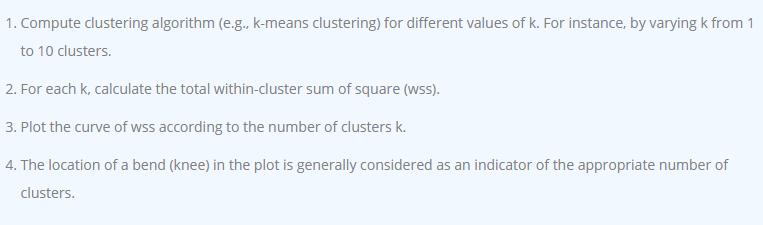

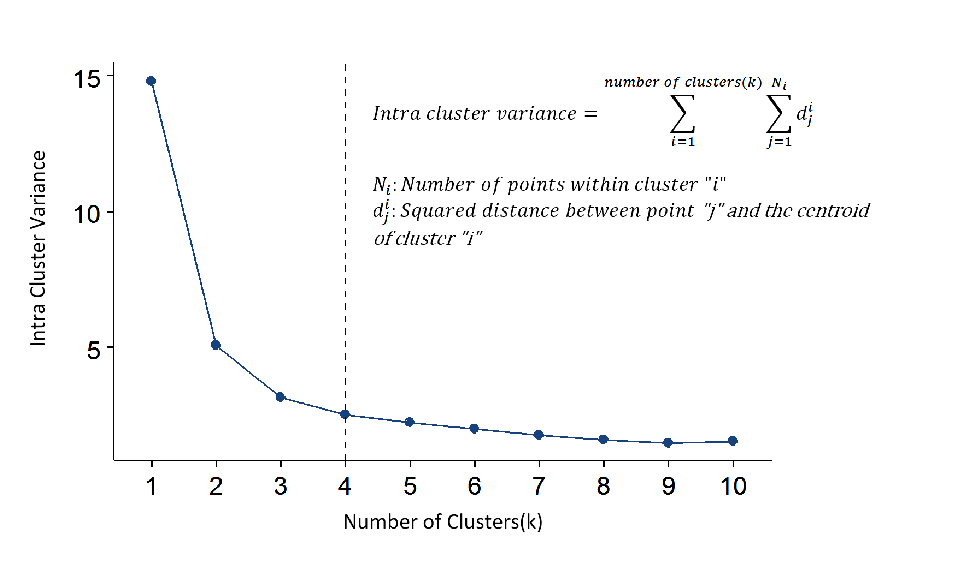


And from this graph, we determine the number of clusters we’d like to keep. To that effect, we use the Elbow-method. The approach consists of looking for a kink or elbow in the WCSS graph. Usually, the part of the graph before the elbow would be steeply declining, while the part after it – much smoother. In this instance, the kink comes at the 7 clusters mark. 

Text(0, 0.5, 'WCSS')

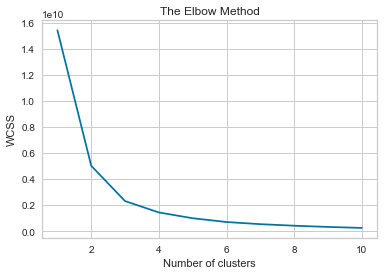

In [83]:
wcss = []
cluster_range = range(1, 11)
for i in cluster_range:
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)
            # generate the plot
plt.plot(cluster_range, wcss)  # creating the graph between WCSS and the number of clusters
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

#### Average silhouette method

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].
Where 1 means that points are very close to their own cluster and far from other clusters, whereas -1 indicates that points are close to the neighboring clusters.

The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.
The silhouette plots can be used to select the most optimal value of the K (no. of cluster) in K-means clustering.
The aspects to look out for in Silhouette plots are cluster scores below the average silhouette score, wide fluctuations in the size of the clusters, and also the thickness of the silhouette plot.

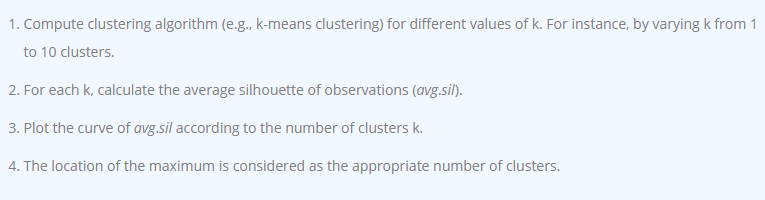

<a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html" >refer SKLearn for code </a>

For n_clusters = 2 The average silhouette_score is : 0.6168169774752235
For n_clusters = 3 The average silhouette_score is : 0.5921198687195769
For n_clusters = 4 The average silhouette_score is : 0.5553436623224265
For n_clusters = 5 The average silhouette_score is : 0.5483397242438969
For n_clusters = 6 The average silhouette_score is : 0.5477836113039588
For n_clusters = 7 The average silhouette_score is : 0.531358975820681


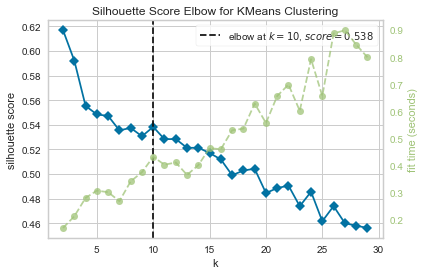

In [84]:
range_n_clusters = [2, 3, 4, 5, 6,7]
avg_silhouette(df,range_n_clusters)

#### Gap statistic method
- Gap Statistic is a method from researchers  Tibshirani, Walther, Hastie to determine the inherent number of clusters in a dataset with k-means clustering.
- API : <a href="https://libraries.io/pypi/gap-stat">here</a>
- Paper :<a href="https://statweb.stanford.edu/~gwalther/gap">here </a>

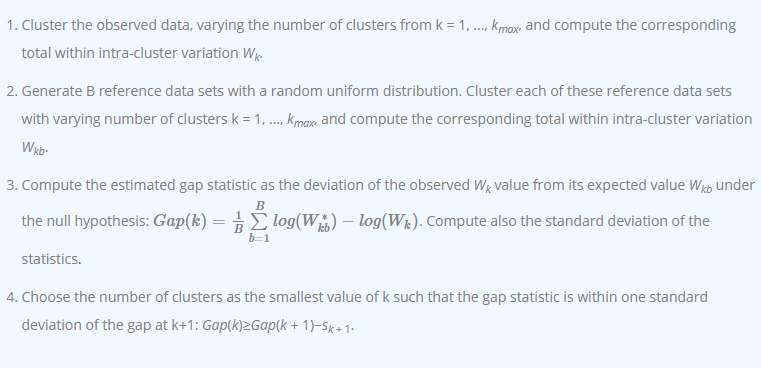

Optimal clusters:  5


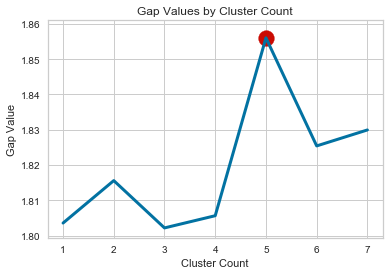

In [85]:
gap_statistics(df)    

### Clustering algorithms

#### K-means

In [86]:
#KMeans++ removes the drawback of K means which is it is dependent on initialization of centroid
kmodel=KMeans(init='k-means++', n_clusters=2, n_init=10,max_iter=500)
kmodel.fit(df)
df['cluster_label']=kmodel.labels_
df.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales  Outlet_Years  \
0         9.30         0.016047  249.8092          3735.1380            10   
1         5.92         0.019278   48.2692           443.4228             0   
2        17.50         0.016760  141.6180          2097.2700            10   
3        19.20         0.017834  182.0950           732.3800            11   
4         8.93         0.009780   53.8614           994.7052            22   

   Item_Fat_Content_0  Item_Fat_Content_1  Outlet_Location_Type_0  \
0                   1                   0                       1   
1                   0                   1                       0   
2                   1                   0                       1   
3                   0                   1                       0   
4                   1                   0                       0   

   Outlet_Location_Type_1  Outlet_Location_Type_2  ...  Outlet_1  Outlet_2  \
0                       0                       0  ...         0         0   
1                       0                       1  ...         0         0   
2                       0                       0  ...         0         0   
3                       0                       1  ...         0         0   
4                       0                       1  ...         1         0   

   Outlet_3  Outlet_4  Outlet_5  Outlet_6  Outlet_7  Outlet_8  Outlet_9  \
0         0         0         0         0         0         0         1   
1         1         0         0         0         0         0         0   
2         0         0         0         0         0         0         1   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   cluster_label  
0              1  
1              0  
2              0  
3              0  
4              0  

[5 rows x 32 columns]

<b>Vizualising the clusters using PCA</b>
>. PCA is an algorithm that is used for dimensionality reduction - meaning, informally, that it can take in a DataFrame with many columns and return a DataFrame with a reduced number of columns that still retains much of the information from the columns of the original DataFrame. The columns of the DataFrame produced from the PCA procedure are called Principal Components. We will use these principal components to help us visualize our clusters in 1-D, 2-D, and 3-D space, since we cannot easily visualize the data we have in higher dimensions.

In [87]:
plot_k_means_2D(df,2)

In [88]:
plot_k_means_3D(df,2)

### Model After Clustering

In [89]:
df.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales  Outlet_Years  \
0         9.30         0.016047  249.8092          3735.1380            10   
1         5.92         0.019278   48.2692           443.4228             0   
2        17.50         0.016760  141.6180          2097.2700            10   
3        19.20         0.017834  182.0950           732.3800            11   
4         8.93         0.009780   53.8614           994.7052            22   

   Item_Fat_Content_0  Item_Fat_Content_1  Outlet_Location_Type_0  \
0                   1                   0                       1   
1                   0                   1                       0   
2                   1                   0                       1   
3                   0                   1                       0   
4                   1                   0                       0   

   Outlet_Location_Type_1  Outlet_Location_Type_2  ...  Outlet_1  Outlet_2  \
0                       0                       0  ...         0         0   
1                       0                       1  ...         0         0   
2                       0                       0  ...         0         0   
3                       0                       1  ...         0         0   
4                       0                       1  ...         1         0   

   Outlet_3  Outlet_4  Outlet_5  Outlet_6  Outlet_7  Outlet_8  Outlet_9  \
0         0         0         0         0         0         0         1   
1         1         0         0         0         0         0         0   
2         0         0         0         0         0         0         1   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   cluster_label  
0              1  
1              0  
2              0  
3              0  
4              0  

[5 rows x 32 columns]

In [90]:
list_of_clusters = df['cluster_label'].unique()

In [91]:
 from sklearn.ensemble import RandomForestRegressor
dict_={}
for i in list_of_clusters:
                # get data for each
    cluster_data = df[df['cluster_label'] == i]

                # step 4.1 get cluster features & labels
    cluster_features =df.drop(['Item_Outlet_Sales', 'cluster_label'], axis=1)
    cluster_label = df['Item_Outlet_Sales']

                # step 4.2 split data into test & train
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(cluster_features,
                                                                                            cluster_label,
                                                                                            test_size=1 / 3,
                                                                                            random_state=0)
      
    scores = []

   
    estimator = RandomForestRegressor()
    estimator.fit(x_train,y_train)
    scores.append(
        {'train_score': estimator.score(x_train,y_train),
         'test_score' :estimator.score(x_test,y_test)
        })    
    dict_[i]=scores

In [92]:
dict_

{1: [{'train_score': 0.9814861935839829, 'test_score': 0.8511212879187413}],
 0: [{'train_score': 0.980229323362237, 'test_score': 0.8490949806204267}]}

In [95]:
final_models={}
for i in dict_.keys():
    inner_list=dict_[i]
    final_models['cluster'+str(i)]=(inner_list[0])
    

In [96]:
pd.DataFrame(final_models).T

train_score  test_score
cluster1     0.981486    0.851121
cluster0     0.980229    0.849095

In [97]:
df.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales',
       'Outlet_Years', 'Item_Fat_Content_0', 'Item_Fat_Content_1',
       'Outlet_Location_Type_0', 'Outlet_Location_Type_1',
       'Outlet_Location_Type_2', 'Outlet_Size_0', 'Outlet_Size_1',
       'Outlet_Size_2', 'Outlet_Size_3', 'Outlet_Type_0', 'Outlet_Type_1',
       'Outlet_Type_2', 'Outlet_Type_3', 'Item_Type_Combined_0',
       'Item_Type_Combined_1', 'Item_Type_Combined_2', 'Outlet_0', 'Outlet_1',
       'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5', 'Outlet_6', 'Outlet_7',
       'Outlet_8', 'Outlet_9', 'cluster_label'],
      dtype='object')

In [98]:

df.groupby(['cluster_label']).agg({
    'mean'
})


Item_Weight Item_Visibility    Item_MRP Item_Outlet_Sales  \
                     mean            mean        mean              mean   
cluster_label                                                             
0               12.977314        0.074199  120.980642       1282.858552   
1               13.094114        0.064434  191.118047       4418.417662   

              Outlet_Years Item_Fat_Content_0 Item_Fat_Content_1  \
                      mean               mean               mean   
cluster_label                                                      
0                10.677947           0.665328           0.334672   
1                12.179842           0.630435           0.369565   

              Outlet_Location_Type_0 Outlet_Location_Type_1  \
                                mean                   mean   
cluster_label                                                 
0                           0.297677               0.330370   
1                           0.241107               0.359025   

              Outlet_Location_Type_2  ... Outlet_0  Outlet_1  Outlet_2  \
                                mean  ...     mean      mean      mean   
cluster_label                         ...                                
0                           0.371953  ...   0.0846  0.106108  0.101233   
1                           0.399868  ...   0.0000  0.121871  0.134387   

               Outlet_3  Outlet_4  Outlet_5  Outlet_6  Outlet_7  Outlet_8  \
                   mean      mean      mean      mean      mean      mean   
cluster_label                                                               
0              0.124176  0.090909  0.057069  0.112704  0.116432  0.106395   
1              0.059947  0.000000  0.218050  0.110013  0.114625  0.116601   

               Outlet_9  
                   mean  
cluster_label            
0              0.100373  
1              0.124506  

[2 rows x 31 columns]

<b> INSIGHTS </b>
- There are no intrinsic clusters in data , since the mean is very close for the two  clusters . Also the model & scores donot change when fitted to data before or after clustering

## Compare multiple regression models using  pycaret

In [99]:
from pycaret.utils import version
version()

'2.2.3'

In [100]:
df.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales',
       'Outlet_Years', 'Item_Fat_Content_0', 'Item_Fat_Content_1',
       'Outlet_Location_Type_0', 'Outlet_Location_Type_1',
       'Outlet_Location_Type_2', 'Outlet_Size_0', 'Outlet_Size_1',
       'Outlet_Size_2', 'Outlet_Size_3', 'Outlet_Type_0', 'Outlet_Type_1',
       'Outlet_Type_2', 'Outlet_Type_3', 'Item_Type_Combined_0',
       'Item_Type_Combined_1', 'Item_Type_Combined_2', 'Outlet_0', 'Outlet_1',
       'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5', 'Outlet_6', 'Outlet_7',
       'Outlet_8', 'Outlet_9', 'cluster_label'],
      dtype='object')

In [101]:
features =list(df.drop(columns=['Item_Outlet_Sales']).columns)

In [102]:
import pycaret
from pycaret.regression import *
reg = setup(df, target = 'Item_Outlet_Sales',numeric_features=features, session_id=786)

In [103]:
compare_models()

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=786, verbose=0, warm_start=False)

In [104]:
create_model('catboost')

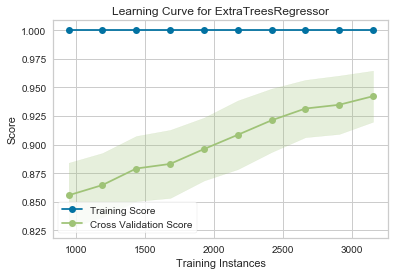

In [105]:
dt=create_model('et')
plot_model(estimator = dt, plot = 'learning')

## References
- Application of Factor Analysis to k-means Clustering Algorithm on Transportation Data.
<a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.673.5439&rep=rep1&type=pdf">Read the
    paper </a>
- <a href="https://medium.com/@masarudheena/4-best-ways-to-find-optimal-number-of-clusters-for-clustering-with-python-code-706199fa957c">Find Optimal Number of Clusters </a>
- <a href="https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c"> Silhouette coefficient </a>
- <a href="https://github.com/milesgranger/gap_statistic/blob/master/Example.ipynb">Gap Statistics</a>
- <a href="https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python">PCA</a>
- <a href="https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2">principal-component-analysis-and-k-means-clustering</a>
- <a href="https://365datascience.com/pca-k-means/" >PCA & Kmeans </a>

- <a href="https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba">Outlier detection & removal </a>

- <a href="https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam#:~:text=The%20value%20of%202%20and,is%20above%20average%20silhouette%20scores.">Silhouette </a>


## FUNCTIONS

In [ ]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

### normalize_df()

In [ ]:
def normalize_df(df):
#normalizing before VIF
    min_max_scaler = preprocessing.MinMaxScaler()
    df_scaled = min_max_scaler.fit_transform(df)
    Scaled_df_used=pd.DataFrame(df_scaled,columns=df.columns.tolist(),index=df.index)
    return df_scaled,Scaled_df_used

### calculate_vif_(X, thresh)

In [ ]:
#VIF Treatment 
from joblib import Parallel, delayed

# Defining the function that you will run later
import time 
from joblib import Parallel, delayed

# Defining the function that you will run later
def calculate_vif_(X, thresh=5):
#     for thresh in thresh:
#         print('running for threshold= ',thresh)
        variables = [X.columns[i] for i in range(X.shape[1])]
        dropped=True
        while dropped:
            dropped=False
            print(len(variables))
            vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) 
                                                for ix in range(len(variables)))

            maxloc = vif.index(max(vif))
            if max(vif) > thresh:
                print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
                variables.pop(maxloc)
                dropped=True

        print('Remaining variables:')
        print([variables])
        #return X[[i for i in variables]]
        return (variables)

### PCA_components(df)

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

def PCA_components(df):
    """
    input to this function is scaled array of dataframe to be used
    """
    pca = PCA()
    pca.fit(df)
    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

    return (px.area(
        x=range(1, exp_var_cumul.shape[0] + 1),
        y=exp_var_cumul,
        labels={"x": "# Components", "y": "Explained Variance"}
    ))
    

### elbow_kmeans(Cluster_data_used)

In [ ]:
#!pip install yellowbrick
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer

def elbow_kmeans(Cluster_data_used):
#within cluster sunm of squares=WCSS
    WCSS = []
    #distortions = []
    for i in range(1,31):
        kmeans = KMeans(n_clusters=i,init = 'k-means++',max_iter=500, n_init = 10, random_state = 0)
        kmeans.fit(Cluster_data_used)
        WCSS.append(kmeans.inertia_)
        #using scipy
        #distortions.append(sum(np.min(cdist(Cluster_data_used, kmeans.cluster_centers_, 'euclidean'), axis=1)) / Cluster_data_used.shape[0])

    plt.plot(range(1,31),WCSS,marker='o', color='c')
    plt.title('The Elbow Method showing the optimal k')
    plt.xlabel('# of clusters')
    plt.ylabel('WCSS')

    plt.show()
    # Elbow Method for K means
    # Import ElbowVisualizer
    
    model = KMeans()
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
    visualizer.fit(Cluster_data_used)        # Fit data to visualizer
    visualizer.show()   
    return 

### avg_silhouette(Cluster_data_used,range_n_clusters)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer

def avg_silhouette(Cluster_data_used,range_n_clusters):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
#         fig, ax1 = plt.subplots(1, 1)
#         fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
#         ax1.set_xlim([-0.1, 1])
#         # The (n_clusters+1)*10 is for inserting blank space between silhouette
#         # plots of individual clusters, to demarcate them clearly.
#         ax1.set_ylim([0, Cluster_data_used.shape[0] + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(Cluster_data_used)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(Cluster_data_used, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
                 
    plt.show()
    
    # Silhouette Score for K means
    # Import ElbowVisualizer
    model = KMeans()
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
    visualizer.fit(Cluster_data_used)        # Fit the data to the visualizer
    visualizer.show() 
    return 

### gap_statistics(Cluster_data_used)

In [ ]:
# !pip install gap-stat==2.0.1
# !pip install gapstat-rs

In [ ]:
# !pip install gap-stat==2.0.1
# !pip install gapstat-rs

from gap_statistic import OptimalK

def gap_statistics(Cluster_data_used):
    optimalK = OptimalK(parallel_backend='rust')
    n_clusters = optimalK(Cluster_data_used, cluster_array=np.arange(1, 8))
    print('Optimal clusters: ', n_clusters)
    #print(optimalK.gap_df)
    plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
    plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
                optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
    plt.grid(True)
    plt.xlabel('Cluster Count')
    plt.ylabel('Gap Value')
    plt.title('Gap Values by Cluster Count')
    plt.show()

### dunn(k_list)

In [ ]:
#function for dun index
#couldnot import jqmcvi so copying the relevant three functions to calculating dunn index

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*10000
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)
    
def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)
    
def dunn(k_list):
    """ Dunn index [CVI]
    
    Parameters
    ----------
    k_list : list of np.arrays
        A list containing a numpy array for each cluster |c| = number of clusters
        c[K] is np.array([N, p]) (N : number of samples in cluster K, p : sample dimension)
    """
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = np.min(deltas)/np.max(big_deltas)
    return di


### get_scores(data,data_with_labels,model,label_column,algorithm_name)

In [ ]:
def get_scores(data,data_with_labels,model,label_column,algorithm_name):
    """
    data is array version of data fit into the model,model is clustering model,
    label_colun is the column that has labels predicted, name of algorithm
    """
    silhouette_score=metrics.silhouette_score(data, model.labels_, metric='euclidean')
    calinski_harabasz_score=metrics.calinski_harabasz_score(data, model.labels_)
    davies_bouldin_score=metrics.davies_bouldin_score(data, model.labels_)
    te=data_with_labels.copy()
    klist=[]
    clus={}
    for i in np.unique(te[label_column]):
        clus[i]=te.loc[te[label_column]==i]
    for (key,values) in clus.items():
        klist.append(clus[key].values)
    dun_val=dunn(klist)
    metrics_=["silhouette_score","calinski_harabasz_score","davies_bouldin_score","dunn index"]
    algorithms_=[algorithm_name]
    score=pd.DataFrame([silhouette_score,calinski_harabasz_score,davies_bouldin_score,dun_val],columns=algorithms_,index=metrics_)
    return score 

### K_means(Cluster_data_used,k)

In [ ]:
from sklearn import metrics
from time import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def K_means(Cluster_data_used,k):
    X=np.array(Cluster_data_used)
    #KMeans++ removes the drawback of K means which is it is dependent on initialization of centroid
    kmodel=KMeans(init='k-means++', n_clusters=k, n_init=10,max_iter=500)
    kmodel.fit(X)
    clusters = kmodel.predict(Cluster_data_used)
    Cluster_data_used_copy=Cluster_data_used.copy()
    Cluster_data_used_copy["Cluster_Kmeans"]=clusters
    score=get_scores(X,Cluster_data_used_copy,kmodel,"Cluster_Kmeans","K-means")
    return score 

### plot_k_means_2D()

In [ ]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

def plot_k_means_2D(df,n_clusters):
    Cluster_data_used=df
    X=np.array(Cluster_data_used)
    #KMeans++ removes the drawback of K means which is it is dependent on initialization of centroid
    kmodel=KMeans(init='k-means++', n_clusters=n_clusters, n_init=10,max_iter=500)
    kmodel.fit(X)
    clusters = kmodel.predict(Cluster_data_used)
    Cluster_data_used_copy=Cluster_data_used.copy()
    Cluster_data_used_copy["Cluster_Kmeans"]=clusters
    ############################################################
    #plotX is a DataFrame containing 5000 values sampled randomly from X
    plotX = pd.DataFrame(np.array(Cluster_data_used_copy))

    #Rename plotX's columns since it was briefly converted to an np.array above
    plotX.columns = Cluster_data_used_copy.columns

    #PCA with one principal component
    pca_1d = PCA(n_components=1)

    #PCA with two principal components
    pca_2d = PCA(n_components=2)

    #PCA with three principal components
    pca_3d = PCA(n_components=3)

    #This DataFrame holds that single principal component mentioned above
    PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotX.drop(["Cluster_Kmeans"], axis=1)))

    #This DataFrame contains the two principal components that will be used
    #for the 2-D visualization mentioned above
    PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster_Kmeans"], axis=1)))

    #And this DataFrame contains three principal components that will aid us
    #in visualizing our clusters in 3-D
    PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotX.drop(["Cluster_Kmeans"], axis=1)))

    PCs_1d.columns = ["PC1_1d"]

    #"PC1_2d" means: 'The first principal component of the components created for 2-D visualization, by PCA.'
    #And "PC2_2d" means: 'The second principal component of the components created for 2-D visualization, by PCA.'
    PCs_2d.columns = ["PC1_2d", "PC2_2d"]

    PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
    #We concatenate these newly created DataFrames to plotX so that they can be used by plotX as columns.
    plotX = pd.concat([plotX,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')

    cluster0 = plotX[plotX["Cluster_Kmeans"] == 0]
    cluster1 = plotX[plotX["Cluster_Kmeans"] == 1]
    cluster2 = plotX[plotX["Cluster_Kmeans"] == 2]
    cluster3 = plotX[plotX["Cluster_Kmeans"] == 3]
    #cluster4 = plotX[plotX["Cluster_Kmeans"] == 4]

#####################################################################
    trace1 = go.Scatter(
                        x = cluster0["PC1_2d"],
                        y = cluster0["PC2_2d"],
                        mode = "markers",
                        name = "Cluster 1",
                        marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                        text = None)

    #trace2 is for 'Cluster 1'
    trace2 = go.Scatter(
                        x = cluster1["PC1_2d"],
                        y = cluster1["PC2_2d"],
                        mode = "markers",
                        name = "Cluster 2",
                        marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                        text = None)

    #trace3 is for 'Cluster 3'
    trace3 = go.Scatter(
                        x = cluster2["PC1_2d"],
                        y = cluster2["PC2_2d"],
                        mode = "markers",
                        name = "Cluster 3",
                        marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                        text = None)

    #trace4 is for 'Cluster 4'
    trace4 = go.Scatter(
                        x = cluster3["PC1_2d"],
                        y = cluster3["PC2_2d"],
                        mode = "markers",
                        name = "Cluster 4",
                        marker = dict(color = 'rgba(255, 255, 100, 0.8)'),
                        text = None)

    # #trace5 is for 'Cluster 5'
    # trace5 = go.Scatter(
    #                     x = cluster4["PC1_2d"],
    #                     y = cluster4["PC2_2d"],
    #                     mode = "markers",
    #                     name = "Cluster 5",
    #                     marker = dict(color = 'rgba(255, 255, 2, 0.8)'),
    #                     text = None)

    data = [trace1, trace2, trace3,trace4]#,trace5]

    title = "Visualizing Clusters in Two Dimensions Using PCA"

    layout = dict(title = title,
                  xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
                 )

    fig = dict(data = data, layout = layout)

    iplot(fig)

### plot_k_means_3D()

In [ ]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

def plot_k_means_3D(df,n_clusters):
    Cluster_data_used=df
    X=np.array(Cluster_data_used)
    #KMeans++ removes the drawback of K means which is it is dependent on initialization of centroid
    kmodel=KMeans(init='k-means++', n_clusters=n_clusters, n_init=10,max_iter=500)
    kmodel.fit(X)
    clusters = kmodel.predict(Cluster_data_used)
    Cluster_data_used_copy=Cluster_data_used.copy()
    Cluster_data_used_copy["Cluster_Kmeans"]=clusters
    ############################################################
    #plotX is a DataFrame containing 5000 values sampled randomly from X
    plotX = pd.DataFrame(np.array(Cluster_data_used_copy))

    #Rename plotX's columns since it was briefly converted to an np.array above
    plotX.columns = Cluster_data_used_copy.columns

    #PCA with one principal component
    pca_1d = PCA(n_components=1)

    #PCA with two principal components
    pca_2d = PCA(n_components=2)

    #PCA with three principal components
    pca_3d = PCA(n_components=3)

    #This DataFrame holds that single principal component mentioned above
    PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotX.drop(["Cluster_Kmeans"], axis=1)))

    #This DataFrame contains the two principal components that will be used
    #for the 2-D visualization mentioned above
    PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster_Kmeans"], axis=1)))

    #And this DataFrame contains three principal components that will aid us
    #in visualizing our clusters in 3-D
    PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotX.drop(["Cluster_Kmeans"], axis=1)))

    PCs_1d.columns = ["PC1_1d"]

    #"PC1_2d" means: 'The first principal component of the components created for 2-D visualization, by PCA.'
    #And "PC2_2d" means: 'The second principal component of the components created for 2-D visualization, by PCA.'
    PCs_2d.columns = ["PC1_2d", "PC2_2d"]

    PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
    #We concatenate these newly created DataFrames to plotX so that they can be used by plotX as columns.
    plotX = pd.concat([plotX,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')

    cluster0 = plotX[plotX["Cluster_Kmeans"] == 0]
    cluster1 = plotX[plotX["Cluster_Kmeans"] == 1]
    cluster2 = plotX[plotX["Cluster_Kmeans"] == 2]
    cluster3 = plotX[plotX["Cluster_Kmeans"] == 3]
    #cluster4 = plotX[plotX["Cluster_Kmeans"] == 4]

#####################################################################
    trace1 = go.Scatter3d(
                    x = cluster0["PC1_3d"],
                    y = cluster0["PC2_3d"],
                    z = cluster0["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

    #trace2 is for 'Cluster 1'
    trace2 = go.Scatter3d(
                        x = cluster1["PC1_3d"],
                        y = cluster1["PC2_3d"],
                        z = cluster1["PC3_3d"],
                        mode = "markers",
                        name = "Cluster 2",
                        marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                        text = None)

    #trace3 is for 'Cluster 3'
    trace3 = go.Scatter3d(
                        x = cluster2["PC1_3d"],
                        y = cluster2["PC2_3d"],
                        z = cluster2["PC3_3d"],
                        mode = "markers",
                        name = "Cluster 3",
                        marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                        text = None)

    #trace4 is for 'Cluster 4'
    trace4 = go.Scatter3d(
                        x = cluster3["PC1_3d"],
                        y = cluster3["PC2_3d"],
                        z = cluster3["PC3_3d"],
                        mode = "markers",
                        name = "Cluster 4",
                        marker = dict(color = 'rgba(255, 255, 100, 0.8)'),
                        text = None)

    # #trace5 is for 'Cluster 5'
    # trace5 = go.Scatter3d(
    #                     x = cluster4["PC1_3d"],
    #                     y = cluster4["PC2_3d"],
    #                     z = cluster4["PC3_3d"],
    #                     mode = "markers",
    #                     name = "Cluster 5",
    #                     marker = dict(color = 'rgba(255, 255, 2, 0.8)'),
    #                     text = None)

    data = [trace1, trace2, trace3,trace4]#,trace5]

    title = "Visualizing Clusters in Three Dimensions Using PCA"

    layout = dict(title = title,
                  xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
                 )

    fig = dict(data = data, layout = layout)

    iplot(fig)
